<a href="https://colab.research.google.com/github/litvinenkonikita/Physics_based_ML/blob/main/Baseline_J_K_Ivan_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Physics-based loss and machine learing approach in application to fluids flow modelling**

# Initialization


## Install libraries

In [129]:
Solver = 'Colab' #'Container', 'Local', 'Colab'
isFirstStart = True

if Solver == 'Colab':
    isFirstStart = True
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
if isFirstStart:
    !pip install neptune

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import libraries

In [131]:
# Pytorch modules
import torch
from torch import nn
from torch import autograd
from torchvision import transforms as T

# Plotting
from matplotlib import pyplot as plt
from matplotlib import transforms
from matplotlib import cm
 
# Arrays
import numpy as np

# Python functions
from collections import namedtuple
from itertools import product
from collections import OrderedDict

# Status bar
from tqdm.notebook import tqdm

# Work with files and images
import json
from pathlib import Path
import os, fnmatch
import re
from PIL import Image, ImageOps
import cv2

# Log with neptune
import neptune.new as neptune
from neptune.new.types import File

# Time
from datetime import datetime
import time

## Constants

In [132]:
# Use 3D
USE_3D = False

# Visualization
SIZE = 16
STEP3D = int(SIZE / 16)
SLICES = [int(SIZE/2), int(SIZE/2), int(SIZE/2)]
VPS = 10 # vector plot step 
FIGSIZE = 5 # figure size

# Load mask
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DATA_DIR = 'tensors_masks'
if Solver == 'Colab':
    os.chdir('/content/drive/MyDrive/study/Publications/2023/NIPS-2023/PhysicsBasedDL')
DATA_DIR = 'tensors_masks' if USE_3D else 'ToyDataset'
WORK_DIR = 'work'

#Show  numbered list of masks
files_list = fnmatch.filter(os.listdir(DATA_DIR), f"*{'.pt' if USE_3D else '.png'}")
print('Files list: \n')
for i, file in enumerate(files_list):
    print(i, file)

Files list: 

0 liver_128_mask.png
1 Parallel plates + cilynder.png
2 Nailfold_capillary_new.png
3 Parallel plates 1x16.png
4 liver_64_mask.png
5 Parallel plates 1x4.png
6 aorta_64.png
7 Parallel plates with notch.png
8 Parallel plates.png
9 aorta_128.png
10 aorta_256.png
11 Nailfold_capillary.png
12 circle.png


In [133]:
# Number of mask
MASK_NUMBER = 5#11

# Training
EPOCHS = 3
IN_CH = 1 # number of input channels
OUT_CH = 4 if USE_3D else 3 # number of output channels

MODEL_NAME = "MLP"#"UNet","MLP" 
EARLY_STOP_PATIENCE = 2000 # number of itarations without improvement
START_WITH_SAVED = False # start training from saved best model
CONTINUE = False # continuation of training in case of interruption
DECAY = 0 # L2 regularization coef
USE_MASK = 1 # 0 - without mask for power loss 1 - mask for flow area 2 - mask for flow area and walls
USE_TORCH_INTEGRAL = False # integral solution type
DIFF_AUTO = False # enable auto differentiation (only for MLP)
DVTEMP = 'sc'
USE_LOG = False # use log with neptune
USE_SINGLE_BOUNDARY = True # ???????????????????????????????????????????????????
if USE_3D:
    W_P = 1000 if DIFF_AUTO else 0 # boundary loss weight
    W_V0  = 1000 if DIFF_AUTO else 0 # velocity on walls loss weight
else:
    W_P = 1000 if DIFF_AUTO else 0 # boundary loss weight
    W_V0  = 100 if DIFF_AUTO else 0 # velocity on walls loss weight

LOG_PARAMETERS = {'START_WITH_SAVED': START_WITH_SAVED,
                  'SIZE': SIZE,
                  'EPOCHS': EPOCHS,
                  'MODEL_NAME': MODEL_NAME,
                  'W_P': W_P,
                  'W_V0': W_V0,
                  'USE_MASK': USE_MASK,
                  'USE_TORCH_INTEGRAL': USE_TORCH_INTEGRAL,
                  'DIFF_AUTO': DIFF_AUTO,
                  'USE_SINGLE_BOUNDARY': USE_SINGLE_BOUNDARY}

HYPS = []

if MODEL_NAME == 'UNet':
    hyps = {"learning_rate": [1e-3],
#             "optimizer": ['adam'],
            "optimizer": ['LBFGS'],
            "scheduler": ["step"],
            "scheduler_factor": [0.1],
            "scheduler_patience": [2000],
            "use_bn": [True],
            "num_of_feat": [32],
            'use_sigmoid': [False]}
else:
    hyps = {"learning_rate": [1e-3],
            "optimizer": ['adam'],
#             "optimizer": ['LBFGS'],
            "scheduler": ["step"],
            "hidden_neurons": [20],
            "hidden_layers": [10],
            "scheduler_factor": [0.1],
            "scheduler_patience": [1000],
            'use_sigmoid': [False]}

    
for i in product(*[hyps[j] for j in hyps]):
    HYPS.append({a:b for a, b in zip(hyps, i)})

## Geometry of the flow domain, fluid properties and boundary conditions

![Flow_domain](https://drive.google.com/uc?id=18P3U3xl7TUOdAX79tShT-sdyln7GI8gO&authuser=avkornaev%40gmail.com&usp=drive_fs)

Geometry

It is convenient to present the flow domain $\Omega$ in the form of a parallelepiped $x_i^- < x_i < x_i^+$ ($\boldsymbol{L} = [l_i] = [x_i^+ - x_i^-]$, $i = 1,2,3$).

In [134]:
# L_1 x L_2 x L_3 flow domain
# L = [0.008, 0.008, 0.52]
# L = [0.064, 0.064, 0.064]
L = [0.4, 1, 0.4]#, [m]
# L = [0.0256, 0.0256, 0.0256]
# L = [0.0832, 0.0832, 0.0832]
# R = L[0] * 3 / 8 #, [m]

# Normalized coordinates, normalized finite diferences, limits and elementary volume
X1N = torch.linspace(0, 1, SIZE)
X2N = torch.linspace(0, 1, SIZE)
X3N = torch.linspace(0, 1, SIZE)

if USE_3D:
    X1, X2, X3 = torch.meshgrid([X1N, X2N, X3N], indexing='ij')
else:
    X1, X3 = torch.meshgrid([X1N, X3N], indexing='ij')
    
X1_1, X1_2 = torch.meshgrid([X2N, X3N], indexing='ij')
X2_1, X2_2 = torch.meshgrid([X1N, X3N], indexing='ij')
X3_1, X3_2 = torch.meshgrid([X1N, X2N], indexing='ij')

DX1N = (X1N[1] - X1N[0]).to(DEVICE)
DX2N = (X2N[1] - X2N[0]).to(DEVICE)
DX3N = (X3N[1] - X3N[0]).to(DEVICE)

LIM1 = [0, L[0]]
LIM2 = [0, L[1]]
LIM3 = [0, L[2]]

D_OMEGA = (DX1N * DX2N * DX3N * L[0] * L[1] * L[2]).to(DEVICE) # elementary volume

Boundary conditions
1. The velocity components $v_i$ are equal to zero on the surfaces and inside the walls. That is zero value mask domain.
2. The pressure values $p^{i-}=p(x_i^-)$, $p^{i+}=p(x_i^+)$ on the edges $x_i = x_i^-$, $x_i = x_i^+$ of the flow domain are given. Those and the other surfaces with given pressure values formulates a set of pressure masks 'masks_p':

In [135]:
#Pressure values pi-
PM = torch.tensor([0, 0, 1E+5 + 2E+1]).to(DEVICE)
#Pressure values pi+
PP = torch.tensor([0, 0, 1E+5]).to(DEVICE)

Normalization

In [136]:
#Characteristic speed
V_CH = 1
#Characteristic pressure
P_CH = torch.stack([PM,PP]).abs().max()

if USE_3D:
    NORM = torch.tensor([V_CH, V_CH, V_CH, P_CH]).reshape(1, -1, 1, 1, 1).to(DEVICE)
else:
    NORM = torch.tensor([V_CH, V_CH, P_CH]).reshape(1, -1, 1, 1).to(DEVICE)

Properties of non-Newtonian fluid and walls that are relatively rigid body.
The Herschel-Bulkley law is applied:
\begin{equation}
    \mu(H)=q_0+q_1H^{z-1},
\end{equation}
where $q_0$, $q_1$, $z$ are the parameters obtained from rheological tests.

In [137]:
#Non-Newtonian fluid viscosity
Q0 = 4e-3
Q1 = 0
Z = 1
# Fluid density, kg/m**3
RHO = 1000
#Newtonian fluid analogue
MU = Q0

#Critical Reynolds number
Re_cr = 1100

#Walls viscosity
Q0W = 1e+0#1e-0#1e+3eye 
Q1W = 0#1e-0
ZW =1#0.5

## Helper functions

In [138]:
def load_3d(ind=None, file_ex='.pt'):
    files_list = fnmatch.filter(os.listdir(DATA_DIR), f'*{file_ex}')
    print('Files list: \n')
    for i, file in enumerate(files_list):
        print(i, file)
    if ind is None:
        ind = int(input('Enter file num: '))
    if file_ex == '.pt':
        mask_tmp = torch.load(os.path.join(DATA_DIR, files_list[ind]))
    else:
        mask_tmp = Image.open(os.path.join(DATA_DIR, files_list[ind])) #open image
        mask_tmp = ImageOps.grayscale(mask_tmp).resize((SIZE, SIZE) ,resample=0)
        mask_tmp = torch.tensor(np.array(mask_tmp) == 255).float()
        mask_tmp = mask_tmp.unsqueeze(0).unsqueeze(2)
        mask_tmp = mask_tmp.repeat(1, 1, SIZE, 1)

    print('\nMask shape: ', mask_tmp.shape)
    
    size_orig = mask_tmp.shape[1]
    
    tmp_split = files_list[ind][:-3].split('_')
    
    resize = T.Resize((SIZE, SIZE), T.InterpolationMode('nearest'))

    mask = torch.zeros((1, mask_tmp.shape[1], SIZE, SIZE))

    for i in range(mask_tmp.shape[1]):
        mask[:, i] = resize(mask_tmp[:, i])

    mask_tmp = mask.clone()

    mask = torch.zeros((1, SIZE, SIZE, SIZE))

    for i in range(SIZE):
        mask[:, :, :, i] = resize(mask_tmp[:, :, :, i])

    mask_contour = torch.zeros_like(mask)
    
    mask_tmp = torch.ones(SIZE + 2, SIZE + 2, SIZE + 2)
    mask_tmp[1:-1, 1:-1, 1:-1] = mask[0]

    for i in range(SIZE):
        for j in range(SIZE):
            for k in range(SIZE):
                if mask[0, i, j, k] and mask_tmp[i:i + 3, j:j + 3, k:k + 3].sum() < 27:
                    mask_contour[0, i, j, k] = 1

#     for i in range(mask.shape[-1]):
#         contours, hierarchy = cv2.findContours(mask[0, :, :, i].numpy().astype('uint8'),
#                                                cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#         image_tmp = cv2.drawContours(torch.zeros_like(mask[0, :, :, int(SIZE // 2)]).numpy(), contours, -1, 1, 1)
        
#         mask_contour[0, :, :, i] = torch.tensor(image_tmp)
        
#         mask_contour[0, mask_contour[0, :, 1, i] == 0, 0 , i] = 0
#         mask_contour[0, mask_contour[0, :, -2, i] == 0, -1, i] = 0
    
    if SIZE == 64:
        s = 1
    elif SIZE == 128:
        s = 0.1
    elif SIZE == 256:
        s = 0.01
    else:
        s = 0.1
    
    x_scatter = np.meshgrid(np.arange(0, SIZE),
                            np.arange(0, SIZE),
                            np.arange(0, SIZE), indexing='ij')
    
    fig = plt.figure(figsize=(FIGSIZE * 2, FIGSIZE * 2))
    ax = fig.add_subplot(projection='3d')
    indices = mask_contour[0].cpu().detach() == 1
    ax.scatter(x_scatter[0][indices],
               x_scatter[1][indices],
               x_scatter[2][indices], c='red', s=s * 50, alpha=0.2)
    ax.bar3d(0, 0, 0., SIZE, SIZE, SIZE, alpha=0.1, edgecolor='black', color='black')
    plt.title('3d mask contour')
    plt.show()
    
    fig = plt.figure(figsize=(FIGSIZE * 2, FIGSIZE * 2))
    ax = fig.add_subplot(projection='3d')
    indices = mask[0].cpu().detach() == 1
    ax.scatter(x_scatter[0][indices],
               x_scatter[1][indices],
               x_scatter[2][indices], c='red', s=s * 50, alpha=0.2)
    ax.bar3d(0, 0, 0., SIZE, SIZE, SIZE, alpha=0.1, edgecolor='black', color='black')
    plt.title('3d mask')
    plt.show()
    
    plt.imshow(mask[0,SLICES[0],:,:])
    plt.title('mask $x_1 = const$')
    plt.colorbar()
    plt.show()
    plt.imshow(mask[0,:,SLICES[1],:])
    plt.title('mask $x_2 = const$')
    plt.colorbar()
    plt.show()
    plt.imshow(mask[0,:,:,SLICES[2]])
    plt.title('mask $x_3 = const$')
    plt.colorbar()
    plt.show()

    inp = mask.clone()
    inp[inp == 1] = torch.randn_like(inp[inp == 1])
    if USE_3D:
        inp = inp.unsqueeze(0)
        
        plt.imshow(inp[0, 0,SLICES[0],:,:])
        plt.title('mask $x_1 = const$')
        plt.colorbar()
        plt.show()
        plt.imshow(inp[0, 0,:,SLICES[1],:])
        plt.title('mask $x_2 = const$')
        plt.colorbar()
        plt.show()
        plt.imshow(inp[0, 0,:,:,SLICES[2]])
        plt.title('mask $x_3 = const$')
        plt.colorbar()
        plt.show()
    else:
        inp = inp[:, :, 0, :].unsqueeze(0)
    
        plt.imshow(inp[0, 0])
        plt.title('input')
        plt.colorbar()
        plt.show()
    
#     psi_contour_mm = torch.zeros(3, SIZE, SIZE)
#     psi_contour_pp = torch.zeros(3, SIZE, SIZE)
    
#     contours, hierarchy = cv2.findContours((psi_1_init[0] > psi_1_init[0].min()).numpy().astype('uint8'),
#                                                cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
#     psi_1_contour = cv2.drawContours(torch.zeros_like(psi_1_init[0]).numpy(), contours, -1, 1, 1)
    
#     contours, hierarchy = cv2.findContours((psi_2_init[0] < psi_2_init[0].max()).numpy().astype('uint8'),
#                                                cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
#     psi_2_contour = cv2.drawContours(torch.zeros_like(psi_1_init[0]).numpy(), contours, -1, 1, 1)
    
#     for i in range(SIZE):
#         psi_contour_mm[0, psi_1_contour[:, i].argmax(), i] = 1
#         psi_contour_pp[0, SIZE - 1 - np.flip(psi_1_contour[:, i], 0).argmax(), i] = 1
        
#         psi_contour_mm[1, psi_2_contour[:, i].argmax(), i] = 1
#         psi_contour_pp[1, SIZE - 1 - np.flip(psi_2_contour[:, i], 0).argmax(), i] = 1
        
#     plt.imshow(psi_contour_mm[0])
#     plt.title('psi 1 contour mm')
#     plt.colorbar()
#     plt.show()
#     plt.imshow(psi_contour_mm[1])
#     plt.title('psi 2 contour mm')
#     plt.colorbar()
#     plt.show()
#     plt.imshow(psi_contour_mm[2])
#     plt.title('psi 3 contour mm')
#     plt.colorbar()
#     plt.show()
    
#     plt.imshow(psi_contour_pp[0])
#     plt.title('psi 1 contour pp')
#     plt.colorbar()
#     plt.show()
#     plt.imshow(psi_contour_pp[1])
#     plt.title('psi 2 contour pp')
#     plt.colorbar()
#     plt.show()
#     plt.imshow(psi_contour_pp[2])
#     plt.title('psi 3 contour pp')
#     plt.colorbar()
#     plt.show()
    
#     plt.imshow(mask_contour[0, :, :, 0])
#     plt.title('x3[0] mask contour')
#     plt.colorbar()
#     plt.show()
#     plt.imshow(mask_contour[0, :, :, int(SIZE // 2)])
#     plt.title('x3[int(SIZE // 2)] mask contour')
#     plt.colorbar()
#     plt.show()
#     plt.imshow(mask_contour[0, :, :, -1])
#     plt.title('x3[-1] mask contour')
#     plt.colorbar()
#     plt.show()
    
    mask_p = torch.zeros(mask.shape[1:] if USE_3D else mask.shape[1:-1])

    if not USE_3D:
        mask_p[:,0] = PM[2]
        mask_p[:,-1] = PP[2]
        mask_p[0, :] = PM[0]
        mask_p[-1,:] = PP[0]
    else:
        mask_p[:,:,0] = PM[2]
        mask_p[:,:,-1] = PP[2]
        mask_p[:,0,:] = PM[1]
        mask_p[:,-1,:] = PP[1]
        mask_p[0,:,:] = PM[0]
        mask_p[-1,:,:] = PP[0]
        
    if USE_3D:
        mask_p[mask[0] == 0] = 0
    else:
        mask_p[mask[0,:,0,:] == 0] = 0
        
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w']
    
    if USE_3D:
        fig = plt.figure(figsize=(FIGSIZE * 2, FIGSIZE * 2))
        ax = fig.add_subplot(projection='3d')
        count = 0
        for i in mask_p.unique():
            if not i:
                continue
            indices = mask_p.cpu().detach() == i
            ax.scatter(x_scatter[0][indices],
                       x_scatter[1][indices],
                       x_scatter[2][indices], c=colors[count], s=s * 50, alpha=0.2)
            count += 1
        ax.bar3d(0, 0, 0., SIZE, SIZE, SIZE, alpha=0.1, edgecolor='black', color='black')
        plt.title('3d mask p')
        plt.show()
    else:
        plt.imshow(mask_p)
        plt.title('mask p')
        plt.colorbar()
        plt.show()
    
    return (mask.to(DEVICE), mask_contour.to(DEVICE), mask_p.to(DEVICE), inp.to(DEVICE))

## Flow domain visualization 

Files list: 

0 liver_128_mask.png
1 Parallel plates + cilynder.png
2 Nailfold_capillary_new.png
3 Parallel plates 1x16.png
4 liver_64_mask.png
5 Parallel plates 1x4.png
6 aorta_64.png
7 Parallel plates with notch.png
8 Parallel plates.png
9 aorta_128.png
10 aorta_256.png
11 Nailfold_capillary.png
12 circle.png

Mask shape:  torch.Size([1, 16, 16, 16])


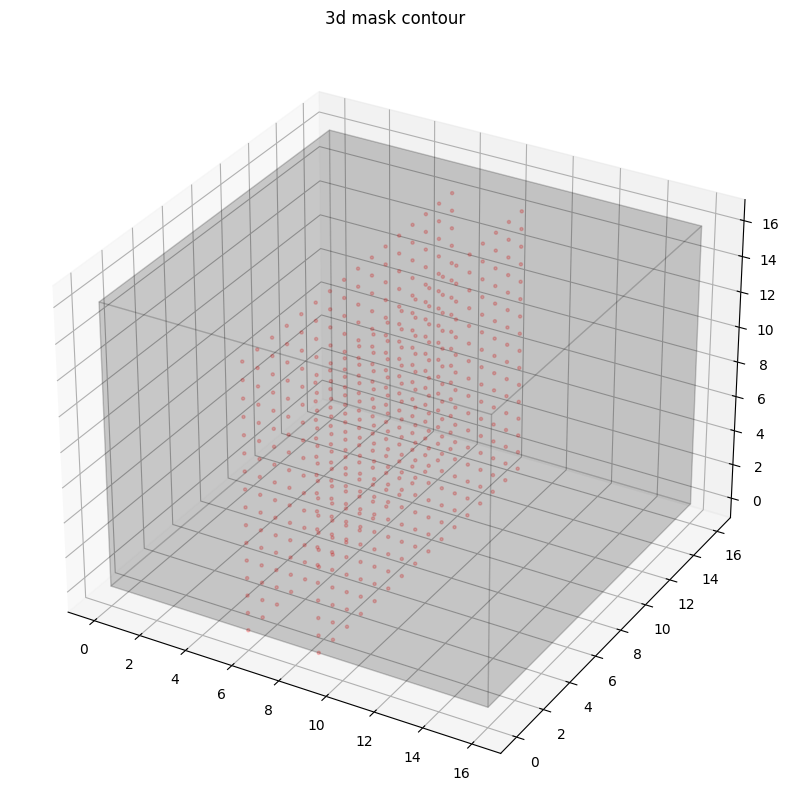

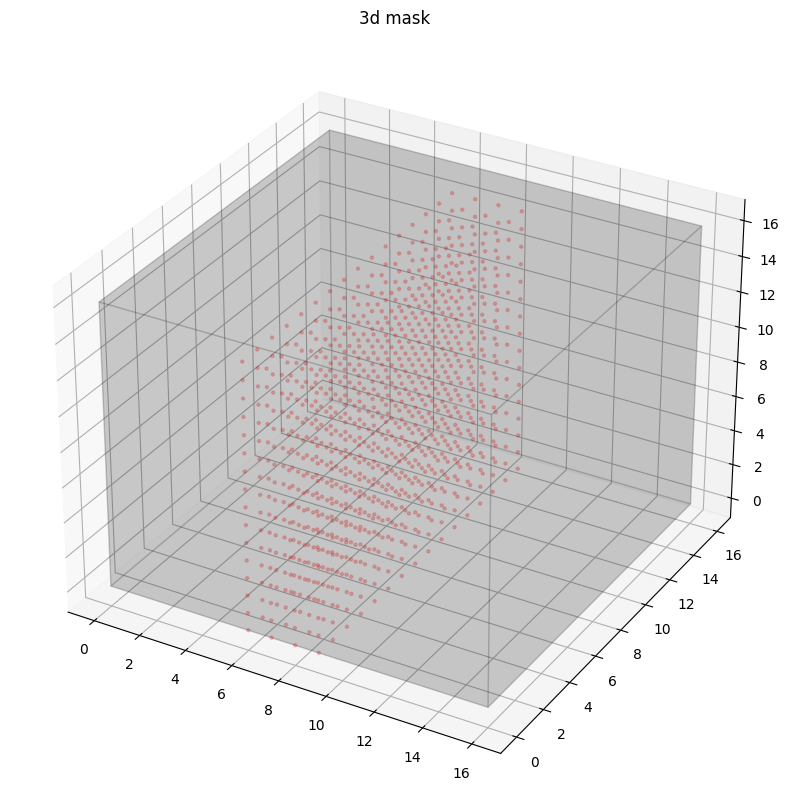

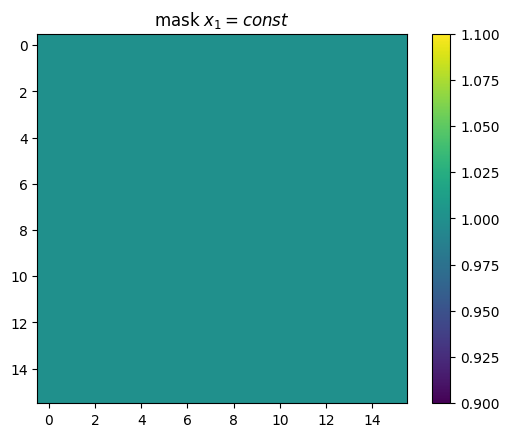

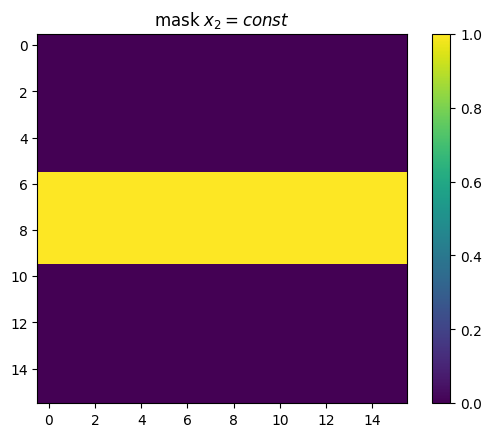

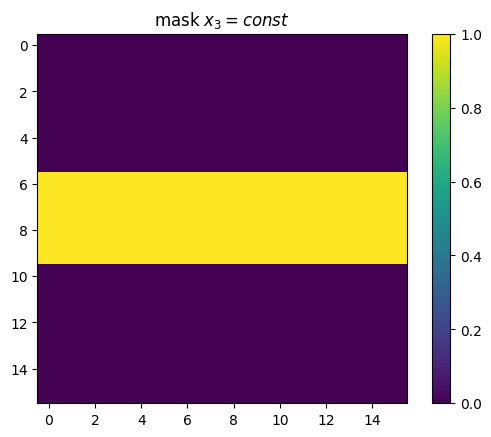

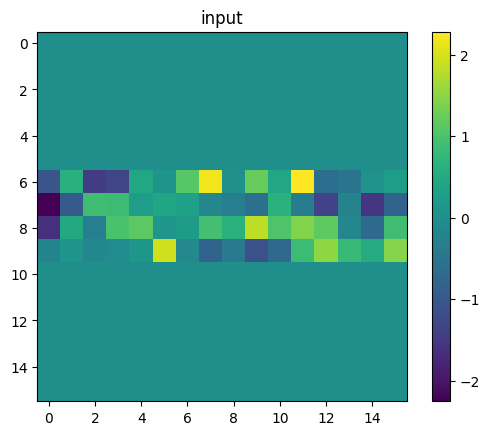

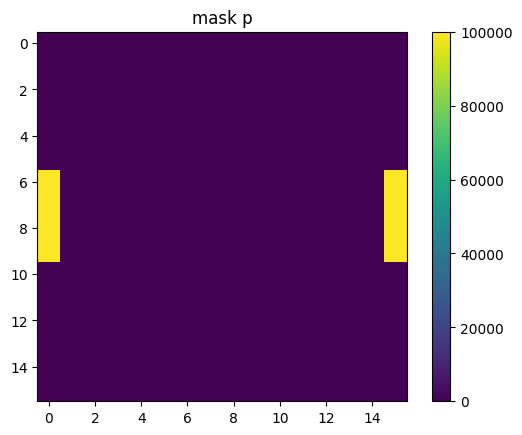

In [139]:
MASK, MASK_CONTOUR, MASK_P, INP = load_3d(
    MASK_NUMBER, '.pt' if USE_3D else '.png')

MASK_ = MASK[0,:,:,:] if USE_3D else MASK[0,:,0,:]
MASK_CONTOUR_ = MASK_CONTOUR[0,:,:,:] if USE_3D else MASK_CONTOUR[0,:,0,:]

# Additional functions
## 3D numerical derivative

In [140]:
def num_diff(f,dx1,dx2,dx3,template='sc'):
    '''The following templates are applied:
    sc - second-order central difference,
    fc - fifth-order central difference.
    Indexing:
    i - index along x_1,
    j - index along x_2,
    k - index along x_3.
    '''
    #Shape
    n1, n2, n3 = f.shape
    
    df_dx1, df_dx2, df_dx3 = torch.zeros(n1, n2, n3), torch.zeros(n1, n2, n3), torch.zeros(n1, n2, n3)
    
    #Device
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
        df_dx3 = df_dx3.to('cuda')
    
    #Derivatives
    if template == 'sc':
        # x1 derivative:
        df_dx1[1:n1-1,:,:] = (f[2:,:,:] - f[:-2,:,:]) / (2 * dx1)
        df_dx1[0,:,:] = (-f[2,:,:] + 4 * f[1,:,:] - 3 * f[0,:,:]) / (2 * dx1)
        df_dx1[n1-1,:,:] = (3 * f[n1-1,:,:] - 4 * f[n1-2,:,:] + f[n1-3,:,:]) / (2 * dx1)
        # x2 derivative:
        df_dx2[:,1:n2-1, :] = (f[:, 2:, :] - f[:, :-2, :]) / (2 * dx2)
        df_dx2[:,0, :] = (- f[:,2,:] + 4 * f[:,1,:] - 3 * f[:, 0, :]) / (2 * dx2)
        df_dx2[:,n2-1, :] = (3 * f[:, n2 - 1, :] - 4 * f[:, n2 - 2, :] + f[:, n2 - 3, :]) / (2 * dx2)
        # x3 derivative:
        df_dx3[:, :, 1:n3-1] = (f[:,:,2:] - f[:,:,:-2]) / (2 * dx3)
        df_dx3[:, :, 0] = (- f[:, :, 2] + 4 * f[:, :, 1] - 3 * f[:, :, 0]) / (2 * dx3)
        df_dx3[:, :, n3-1] = (3 * f[:, :, n3 - 1] - 4 * f[:, :, n3 - 2] + f[:, :, n3 - 3]) / (2 * dx3)
    elif template == 'fc':
        # x1 derivative
        df_dx1[2:n1-2, :, :] = (-f[4:, :,:] + 8 * f[3:n1-1, :, :] - 8 * f[1:n1-3, :, :] + f[:n1-4, :, :]) / (12 * dx1)
        df_dx1[0, :, :] = (-3 * f[4, :, :] + 16 * f[3, :, :] - 36 * f[2, :, :] + 48 * f[1, :,:] - 25 * f[0, :, :]) / (12 * dx1)
        df_dx1[1, :, :] = (f[4, :, :] - 6 * f[3, :, :] + 18 * f[2, :, :] - 10 * f[1, :, :] - 3 * f[0, :, :]) / (12 * dx1)
        df_dx1[n1-2, :, :] = (3 * f[n1-1, :, :] + 10 * f[n1-2, :, :] - 18 * f[n1-3, :, :] + 6 * f[n1-4, :, :] - f[n1-5, :, :]) / (12 * dx1)
        df_dx1[n1-1, :, :] = (25 * f[n1-1, :, :] - 48 * f[n1-2, :, :] + 36 * f[n1-3, :, :] - 16 * f[n1-4, :, :] + 3*f[n1-5, :, :]) / (12 * dx1)
        
        # x2 derivative
        df_dx2[:, 2:n2-2, :] = (-f[:, 4:, :] + 8 * f[:, 3:n2-1, :] - 8 * f[:, 1:n2-3, :] + f[:, :n2-4, :]) / (12 * dx2)
        df_dx2[:, 0, :] = (-3 * f[:,4, :] + 16 * f[:, 3, :] - 36 * f[:, 2, :] + 48 * f[:, 1, :] - 25 * f[:, 0, :]) / (12*dx2)
        df_dx2[:, 1, :] = (f[:, 4, :] - 6 * f[:, 3, :] + 18 * f[:, 2, :] - 10 * f[:, 1, :] - 3 * f[:, 0, :]) / (12*dx2)
        df_dx2[:, n2-2, :] = (3 * f[:, n2-1, :] + 10 * f[:, n2-2, :] - 18 * f[:, n2-3, :] + 6 * f[:, n2-4, :] - f[:, n2-5, :]) / (12*dx2)
        df_dx2[:, n2-1, :] = (25 * f[:, n2-1, :] - 48 * f[:, n2-2, :] + 36 * f[:, n2-3, :] - 16 * f[:, n2-4, :] + 3 * f[:,n2-5, :]) / (12*dx2)       
        # x3 derivative
        df_dx3[:, :, 2:n3-2] = (-f[:, :, 4:] + 8 * f[:, :, 3:n3-1] - 8 * f[:, :, 1:n3-3] + f[:, :, :n3-4]) / (12 * dx3)
        df_dx3[:, :, 0] = (-3 * f[:, :, 4] + 16 * f[:, :, 3] - 36 * f[:, :, 2] + 48 * f[:, :, 1] - 25 * f[:, :, 0]) / (12 * dx3)
        df_dx3[:, :, 1] = (f[:, :, 4] - 6 * f[:, :, 3] + 18 * f[:, :, 2] - 10 * f[:, :, 1] - 3 * f[:, :, 0]) / (12 * dx3)
        df_dx3[:, :, n3-2] = (3 * f[:, :, n3-1] + 10 * f[:, :, n3-2] - 18 * f[:, :, n3-3] + 6 * f[:,:,n3-4] - f[:, :, n3-5]) / (12 * dx3)
        df_dx3[:, :, n3-1] = (25 * f[:,:, n3-1] - 48 * f[:,:, n3-2] + 36 * f[:,:, n3-3] - 16 * f[:,:, n3-4] + 3*f[:,:, n3-5]) / (12 * dx3)
    
    #We can't do like that! On the surface some derivatives are not equal to zero!!!!!!!!!!!!!!!
    # if USE_MASK:
    #     return df_dx1 * MASK_, df_dx2 * MASK_, df_dx3 * MASK_
    # else:
    #     return df_dx1, df_dx2, df_dx3 
    return df_dx1, df_dx2, df_dx3

## 2D numerical derivative

In [141]:
def num_diff2D(f,dx1,dx2,template=DVTEMP):
    '''The following templates are applied:
    sc - second-order central difference,
    fc - fifth-order central difference.
    Indexing:
    i - index along x_1,
    j - index along x_2.
    '''
    #Shape
    n1, n2 = f.shape
    
    df_dx1, df_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    
    #Device
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
            
    #Derivatives
    if template == 'sc':
        # x1 derivative:
        df_dx1[1:n1-1,:] = (f[2:,:] - f[:-2,:]) / (2 * dx1)
        df_dx1[0,:] = (-f[2,:] + 4 * f[1,:] - 3 * f[0,:]) / (2 * dx1)
        df_dx1[n1-1,:] = (3 * f[n1-1,:] - 4 * f[n1-2,:] + f[n1-3,:]) / (2 * dx1)
        # x2 derivative:
        df_dx2[:,1:n2-1] = (f[:, 2:] - f[:, :-2]) / (2 * dx2)
        df_dx2[:,0] = (- f[:,2] + 4 * f[:,1] - 3 * f[:, 0]) / (2 * dx2)
        df_dx2[:,n2-1] = (3 * f[:, n2 - 1] - 4 * f[:, n2 - 2] + f[:, n2 - 3]) / (2 * dx2)
    elif template == 'fc':
        # 1st order x1 derivative:
        # x1 derivative
        df_dx1[2:n1-2, :] = (-f[4:, :] + 8 * f[3:n1-1, :] - 8 * f[1:n1-3, :] + f[:n1-4, :]) / (12 * dx1)
        df_dx1[0, :] = (-3 * f[4, :] + 16 * f[3, :] - 36 * f[2, :] + 48 * f[1, :] - 25 * f[0, :]) / (12 * dx1)
        df_dx1[1, :] = (f[4, :] - 6 * f[3, :] + 18 * f[2, :] - 10 * f[1, :] - 3 * f[0, :]) / (12 * dx1)
        df_dx1[n1-2, :] = (3 * f[n1-1, :] + 10 * f[n1-2, :] - 18 * f[n1-3, :] + 6 * f[n1-4, :] - f[n1-5, :]) / (12 * dx1)
        df_dx1[n1-1, :] = (25 * f[n1-1, :] - 48 * f[n1-2, :] + 36 * f[n1-3, :] - 16 * f[n1-4, :] + 3*f[n1-5, :]) / (12 * dx1)
        
        # x2 derivative
        df_dx2[:, 2:n2-2] = (-f[:, 4:] + 8 * f[:, 3:n2-1] - 8 * f[:, 1:n2-3] + f[:, :n2-4]) / (12 * dx2)
        df_dx2[:, 0] = (-3 * f[:,4] + 16 * f[:, 3] - 36 * f[:, 2] + 48 * f[:, 1] - 25 * f[:, 0]) / (12*dx2)
        df_dx2[:, 1] = (f[:, 4] - 6 * f[:, 3] + 18 * f[:, 2] - 10 * f[:, 1] - 3 * f[:, 0]) / (12*dx2)
        df_dx2[:, n2-2] = (3 * f[:, n2-1] + 10 * f[:, n2-2] - 18 * f[:, n2-3] + 6 * f[:, n2-4] - f[:, n2-5]) / (12*dx2)
        df_dx2[:, n2-1] = (25 * f[:, n2-1] - 48 * f[:, n2-2] + 36 * f[:, n2-3] - 16 * f[:, n2-4] + 3 * f[:,n2-5]) / (12*dx2)   
    
    #We can't do like that! On the surface some derivatives are not equal to zero!!!!!!!!!!!!!!!     
    # ind_p = MASK_P != 0
    # df_dx1[ind_p] = 0
    # df_dx2[ind_p] = 0
    # if USE_MASK:
    #     return df_dx1 * MASK_, df_dx2 * MASK_
    # else:
    #     return df_dx1, df_dx2
    return df_dx1, df_dx2

## 3D auto derivative

In [142]:
def diff_auto_3d(f, x1, x2, x3):
    df_dx1 = autograd.grad(f.sum(), x1, create_graph=True)[0]
    df_dx2 = autograd.grad(f.sum(), x2, create_graph=True)[0]
    df_dx3 = autograd.grad(f.sum(), x3, create_graph=True)[0]
    if USE_MASK:
        return (df_dx1.reshape(SIZE, SIZE, SIZE) * MASK_,
                df_dx2.reshape(SIZE, SIZE, SIZE) * MASK_,
                df_dx3.reshape(SIZE, SIZE, SIZE) * MASK_)
    else:
        return df_dx1.reshape(SIZE, SIZE, SIZE), df_dx2.reshape(SIZE, SIZE, SIZE), df_dx3.reshape(SIZE, SIZE, SIZE)

## 2D auto derivative

In [143]:
def diff_auto(f, x1, x2):
    df_dx1 = autograd.grad(f.sum(), x1, create_graph=True)[0]
    df_dx2 = autograd.grad(f.sum(), x2, create_graph=True)[0]
    if USE_MASK:
        return df_dx1.reshape(SIZE, SIZE) * MASK_, df_dx2.reshape(SIZE, SIZE) * MASK_
    else:
        return df_dx1.reshape(SIZE, SIZE), df_dx2.reshape(SIZE, SIZE)

## 3D numerical integration (Simpson method)

In [144]:
def int_func_simpson_3d(f, dx, dy, dz):
    '''
    f - 3d-dimentional tensor
    dx, dy, dz - constant step along the corresponding coordinate
    '''
    n1,n2,n3 = f.shape
    # integrate by dz:
    if n3%2 == 0:
        J3 = (f[:,:,0:n3-2:2] + 4*f[:,:,1:n3-2:2] + f[:,:,2::2]).sum(dim=2)*dz/3 + (f[:,:,-1]+f[:,:,-2])*dz/2
    else:
        J3 = (f[:,:,0:n3-1:2] + 4*f[:,:,1:n3-1:2] + f[:,:,2::2]).sum(dim=2)*dz/3

    # integrate by dy:
    if n2%2 == 0:
        J2 = (J3[:,0:n2-2:2] + 4*J3[:,1:n2-2:2] + J3[:,2::2]).sum(dim=1)*dy/3 + (J3[:,-1]+J3[:,-2])*dy/2
    else:
        J2 = (J3[:,0:n2-1:2] +4 *J3[:,1:n2-1:2] + J3[:,2::2]).sum(dim=1)*dy/3

    # integrate by dx:
    if n1%2 == 0:
        J1 = (J2[0:n1-2:2] + 4*J2[1:n1-2:2] + J2[2::2]).sum(dim=0)*dx/3 + (J2[-1]+J2[-2])*dx/2
    else:
        J1 = (J2[0:n1-1:2] + 4*J2[1:n1-1:2] + J2[2::2]).sum(dim=0)*dx/3

    return J1

## 2D numerical integration (Simpson method)

In [145]:
def int_func_simpson_2d(f, dx, dy):
    '''
    f - 2d-dimentional tensor
    dx, dy - constant step along the corresponding coordinate
    '''
    n1, n2 = f.shape
    # integrate by dy:
    if n2%2 == 0:
        J2 = (f[:,0:n2-2:2]+ 4*f[:,1:n2-2:2] + f[:,2::2]).sum(dim=1)*dy/3 + (f[:,-1]+f[:,-2])*dy/2
    else:
        J2 = (f[:,0:n2-1:2] +4*f[:,1:n2-1:2]+f[:,2::2]).sum(dim=1)*dy/3
    # integrate by dx:
    if n1%2 == 0:
        J1 = (J2[0:n1-2:2]+ 4*J2[1:n1-2:2] + J2[2::2]).sum(dim=0)*dx/3 + (J2[-1]+J2[-2])*dx/2
    else:
        J1 = (J2[0:n1-1:2] +4*J2[1:n1-1:2]+J2[2::2]).sum(dim=0)*dx/3
    return J1

# Visualization functions

In [146]:
def vector_plot(x, y, u, v, gradmag, FIGSIZE, vptitle='vector_plot', xlabel='$x_i$', ylabel='$x_j$',step=10):
    
    plt.pcolor(x, y, gradmag, cmap='rainbow')
    plt.colorbar()
    plt.quiver(x[::step,::step], y[::step,::step], u[::step,::step], v[::step,::step])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(vptitle)
    
    
def vector_plot_3d(x, v, v_abs, figSize=FIGSIZE, step=1, use_color=False, use_full_mask=False):
    fig = plt.figure(figsize=(figSize, figSize))
    ax = fig.add_subplot(projection='3d')
    if SIZE == 64:
        s = 1
    elif SIZE == 128:
        s = 0.1
    elif SIZE == 256:
        s = 0.01
    else:
        s = 0.1
    norm = plt.Normalize()
    colors = plt.cm.jet(norm(v_abs[::step, ::step, ::step]))
    
    x_scatter = np.meshgrid(np.arange(0, SIZE),
                            np.arange(0, SIZE),
                            np.arange(0, SIZE), indexing='ij')
    
    if use_full_mask:
        indices = MASK[0].cpu().detach() == 1
        ax.scatter(x_scatter[0][indices],
                   x_scatter[1][indices],
                   x_scatter[2][indices], c='red', s=s * 50, alpha=0.2)
    else:
        indices = MASK_CONTOUR[0].cpu().detach() == 1
        ax.scatter(x_scatter[0][indices],
                   x_scatter[1][indices],
                   x_scatter[2][indices], c='red', s=s * 50, alpha=0.2)
        
    ax.quiver(x[0], x[1], x[2], v[::step, ::step, ::step, 0],
              v[::step, ::step, ::step, 1],
              v[::step, ::step, ::step, 2],
              color=colors.reshape(-1, 4) if use_color else 'b', length=10)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel(f'$x_1$')
    ax.set_ylabel(f'$x_2$')
    ax.set_zlabel(f'$x_3$')
    ax.bar3d(0, 0, 0., SIZE, SIZE, SIZE, alpha=0.1, edgecolor='black', color='black')
    plt.show()
    
    
def flowVisualization(p, v1, v2, v3, v_abs, step=15,slices=SLICES, use_mask=False):
    nr=2
    nc=3
    
    #Velocity distribution
    v = torch.stack([v1, v2, v3])
    
    indices = [1, 2, 0, 2, 0, 1]
    
    print('Pressure Visualization')
    fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
    for i in range(3):
        if i == 0:
            p_tmp = p[slices[0], :, :]
        elif i == 1:
            p_tmp = p[:, slices[1], :]
        else:
            p_tmp = p[:, :, slices[2]]
        plt.subplot(nr,nc,i+1)
        plt.imshow(p_tmp, extent=(0, L[indices[i * nr + 1]], L[indices[i * nr ]], 0), aspect='auto')
        plt.colorbar()
        plt.ylabel(f'$x_{indices[i * nr] + 1}$')
        plt.xlabel(f'$x_{indices[i * nr + 1] + 1}$')
        plt.title(f'$x_{i + 1} = const$')
        plt.subplot(nr,nc,i+1+nc)
        if i == 0:
            plt.plot(X2N * L[1], p_tmp[:,slices[2]])
            plt.title(f'$x_1 = const$, $x_3 = const$')
            plt.xlabel(f'$x_2$')
        elif i == 1:
            plt.plot(X1N * L[0], p_tmp[slices[0],:])
            plt.title(f'$x_1 = const$, $x_2 = const$')
            plt.xlabel(f'$x_1$')
        elif i == 2:
            plt.plot(X3N * L[2], p_tmp[slices[1],:])
            plt.title(f'$x_2 = const$, $x_3 = const$')
            plt.xlabel(f'$x_{indices[i * nr] + 1}$')
        plt.ylabel(f'$p$')
        plt.grid()
    plt.show()
    
    print()
    print('Velocity distribution visualization without flow domain mask (first line) and with mask (second line)')

    XN = torch.meshgrid(X1N * L[0], X2N * L[1], X3N * L[2], indexing='ij')
    
    fig1 = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
    #without flow domain mask 
    plt.subplot(nr,nc,1)
    vector_plot(XN[2][slices[0],:,:], XN[1][slices[0],:,:], v[2,slices[0],:,:] / L[2], v[1,slices[0],:,:] / L[1],
                np.sqrt(v[2,slices[0],:,:]**2 + v[1,slices[0],:,:]**2),
                FIGSIZE, vptitle='$x_1 = const$', xlabel='$x_3$', ylabel='$x_2$', step=step)
    plt.subplot(nr,nc,2)
    vector_plot(XN[2][:,slices[1],:], XN[0][:,slices[1],:], v[2,:,slices[1],:] / L[2], v[0,:,slices[1],:] / L[0],
                np.sqrt(v[2,:,slices[1],:]**2 + v[0,:,slices[1],:]**2),
                FIGSIZE, vptitle='$x_2 = const$', xlabel='$x_3$', ylabel='$x_1$', step=step)
    plt.subplot(nr,nc,3)
    vector_plot(XN[1][:,:,slices[2]], XN[0][:,:,slices[2]], v[1,:,:,slices[2]] / L[1], v[0,:,:,slices[2]] / L[0],
                np.sqrt(v[1,:,:,slices[2]]**2 + v[0,:,:,slices[2]]**2),
                FIGSIZE, vptitle='$x_3 = const$', xlabel='$x_2$', ylabel='$x_1$', step=step)
    #with flow domain mask 
    plt.subplot(nr,nc,4)
    vector_plot(XN[2][0,:,:], XN[1][0,:,:], v[2,slices[0],:,:] * MASK[0,slices[0],:,:].to('cpu') / L[2],
                v[1,slices[0],:,:] * MASK[0,slices[0],:,:].to('cpu') / L[1],
                np.sqrt(v[2,slices[0],:,:]**2 + v[1,slices[0],:,:]**2) * MASK[0,slices[0],:,:].to('cpu'),
                FIGSIZE, vptitle='$x_1 = const$', xlabel='$x_3$', ylabel='$x_2$', step=step)
    plt.subplot(nr,nc,5)
    vector_plot(XN[2][:,0,:], XN[0][:,0,:], v[2,:,slices[1],:] * MASK[0,:,slices[1],:].to('cpu') / L[2],
                v[0,:,slices[1],:] * MASK[0,:,slices[1],:].to('cpu') / L[0],
                np.sqrt(v[2,:,slices[1],:]**2 + v[0,:,slices[1],:]**2) * MASK[0,:,slices[1],:].to('cpu'),
                FIGSIZE, vptitle='$x_2 = const$', xlabel='$x_3$', ylabel='$x_1$', step=step)
    plt.subplot(nr,nc,6)
    vector_plot(XN[1][:,:,0], XN[0][:,:,0], v[1,:,:,slices[2]] * MASK[0,:,:,slices[2]].to('cpu') / L[1],
                v[0,:,:,slices[2]] * MASK[0,:,:,slices[2]].to('cpu') / L[0],
                np.sqrt(v[1,:,:,slices[2]]**2 + v[0,:,:,slices[2]]**2) * MASK[0,:,:,slices[2]].to('cpu'),
                FIGSIZE, vptitle='$x_3 = const$', xlabel='$x_2$', ylabel='$x_1$', step=step)
    plt.show()
    
    #Check the flow rates Q3-,Q3+
    Q1mch = int_func_simpson_2d((v * MASK[0].cpu())[0, 0, :, :], L[1] * DX2N.to('cpu'), L[2] * DX3N.to('cpu'))
    Q1pch = int_func_simpson_2d((v * MASK[0].cpu())[0,-1, :, :], L[1] * DX2N.to('cpu'), L[2] * DX3N.to('cpu'))
    
    Q2mch = int_func_simpson_2d((v * MASK[0].cpu())[1, :, 0, :], L[0] * DX1N.to('cpu'), L[2] * DX3N.to('cpu'))
    Q2pch = int_func_simpson_2d((v * MASK[0].cpu())[1, :,-1, :], L[0] * DX1N.to('cpu'), L[2] * DX3N.to('cpu'))
    
    Q3mch = int_func_simpson_2d((v * MASK[0].cpu())[2, :, :, 0], L[0] * DX1N.to('cpu'), L[1] * DX2N.to('cpu'))
    Q3pch = int_func_simpson_2d((v * MASK[0].cpu())[2, :, :,-1], L[0] * DX1N.to('cpu'), L[1] * DX2N.to('cpu'))
    
    print(f'{v[0].min()} < v_1 < {v[0].max()},')
    print(f'{v[1].min()} < v_2 < {v[1].max()},')
    print(f'{v[2].min()} < v_3 < {v[2].max()},')
    # print(f'Q1- = {QM[0]}, Q1+ = {QP[0]} - target')
    print(f'Q1- = {Q1mch}, Q1+ = {Q1pch} - solution')
    # print(f'Q2- = {QM[1]}, Q2+ = {QP[1]} - target')
    print(f'Q2- = {Q2mch}, Q2+ = {Q2pch} - solution')
    # print(f'Q3- = {QM[2]}, Q3+ = {QP[2]} - target')
    print(f'Q3- = {Q3mch}, Q3+ = {Q3pch} - solution')
    
    print(f'v_abs[0,0,0] = {v_abs[0,0,0]}, v_abs[0,0,-1] = {v_abs[0,0,-1]}, v_abs[0,-1,0] = {v_abs[0,-1,0]}, v_abs[0,-1,-1] = {v_abs[0,-1,-1]}, v_abs[-1,0,0] = {v_abs[-1,0,0]}, v_abs[-1,0,-1] = {v_abs[-1,0,-1]}, v_abs[-1,-1,0] = {v_abs[-1,-1,0]}, v_abs[-1,-1,-1] = {v_abs[-1,-1,-1]},')
    
    print()
    
    if DIFF_AUTO:
        print('Boundary velocity check')

        plt.figure(figsize=(FIGSIZE, FIGSIZE))
        plt.title('${v_{abs}}$ on boundary')
        plt.boxplot(v_abs[MASK_CONTOUR[0].cpu().detach().numpy() == 1], labels=['${v_{abs}}$'])
        plt.show()
  
    return


def v_contours_and_slices(v, ind):
    fig = plt.figure(figsize=(FIGSIZE * 3, FIGSIZE * 3))

    plt.subplot(3,3,1)
    plt.title('$v_{' + str(ind) + '}$' + f'$(x_1=const,x_2,x_3)$')
    plt.imshow(v[SLICES[0],:,:], extent=(0, L[2], L[1], 0), aspect='auto')
    plt.ylabel('$x_2$') 
    plt.xlabel('$x_3$') 
    plt.colorbar()

    plt.subplot(3,3,2)
    plt.plot(X3N * L[2], v[SLICES[0],SLICES[1],:])
    plt.title(f'$(x_1=const,x_2=const,x_3)$')
    plt.ylabel('$v_{' + str(ind) + '}$')
    plt.xlabel('$x_3$')
    plt.grid()

    plt.subplot(3,3,3)
    plt.plot(X2N * L[1], v[SLICES[0],:,SLICES[2]])
    plt.title(f'$(x_1=const,x_2,x_3=const)$')
    plt.ylabel('$v_{' + str(ind) + '}$')
    plt.xlabel('$x_2$')
    plt.grid()


    plt.subplot(3,3,4)
    plt.title('$v_{' + str(ind) + '}$' + f'$(x_1,x_2=const,x_3)$')
    plt.imshow(v[:,SLICES[1],:], extent=(0, L[2], L[0], 0), aspect='auto')
    plt.ylabel('$x_1$')
    plt.xlabel('$x_3$')
    plt.colorbar()

    plt.subplot(3,3,5)
    plt.plot(X3N * L[2], v[SLICES[0],SLICES[1],:])
    plt.title(f'$(x_1=const,x_2=const,x_3)$')
    plt.ylabel('$v_{' + str(ind) + '}$')
    plt.xlabel('$x_3$')
    plt.grid()

    plt.subplot(3,3,6)
    plt.plot(X1N * L[0], v[:,SLICES[1],SLICES[2]])
    plt.title(f'$(x_1,x_2=const,x_3=const)$')
    plt.ylabel('$v_{' + str(ind) + '}$')
    plt.xlabel('$x_1$')
    plt.grid()


    plt.subplot(3,3,7)
    plt.title('$v_{' + str(ind) + '}$' + f'$(x_1,x_2,x_3=const)$')
    plt.imshow(v[:,:,SLICES[2]], extent=(0, L[1], L[0], 0), aspect='auto')
    plt.ylabel('$x_1$')
    plt.xlabel('$x_2$')
    plt.colorbar()

    plt.subplot(3,3,8)
    plt.plot(X2N * L[1], v[SLICES[0],:,SLICES[2]])
    plt.title(f'$(x_1=const,x_2,x_3=const)$')
    plt.ylabel('$v_{' + str(ind) + '}$')
    plt.xlabel('$x_2$')
    plt.grid()

    plt.subplot(3,3,9)
    plt.plot(X1N * L[0], v[:,SLICES[1],SLICES[2]])
    plt.title(f'$(x_1,x_2=const,x_3=const)$')
    plt.ylabel('$v_{' + str(ind) + '}$')
    plt.xlabel('$x_1$')
    plt.grid()
    plt.subplots_adjust(wspace=0.35)
    plt.show()
    
    
def v_surf(v, x1, x2, ind):
    fig, ax = plt.subplots(figsize=(FIGSIZE*2, FIGSIZE*2),subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(np.array(x1),np.array(x2), np.array(v[:,:,SLICES[2]]),
                           cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.title('$v_{' + str(ind) + '}$' + f'$(x_1,x_2,x_3=const)$')
    ax.set_xlabel(f'$x_1$')
    ax.set_ylabel(f'$x_2$')
    ax.set_zlabel('$v_{' + str(ind) + '}$')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# Physics

The unknown functions are the velocity $\boldsymbol{V} = [v_i]$ that has zero values on the walls and pressure $p$ that has fixed values on boundaries of the flow domain together with their first and second derivatives.

Taking into account the symmetry of the shear rate tensor $\xi_{i,j}=\xi_{i,j}$, the tensor has the following form:

\begin{equation}
    \boldsymbol{T}_\xi= \frac{1}{2}   
    [[\frac{\partial v_i}{\partial x_j} + \frac{\partial v_j}{\partial x_i}]].
\end{equation}

In the general case of a three dimensional flow the shear strain rate intensity $H$ depends on all the components of the shear rate tensor:
\begin{equation}
    H =\sqrt{2(\xi_{11}^2 + \xi_{22}^2 + \xi_{33}^2 + 2\xi_{12}^2 + 2\xi_{13}^2 + 2\xi_{23}^2)}. 
\end{equation}

In [147]:
# # Unused at the moment
# def mixed_bc(p,Jv=torch.zeros_like(MASK_P), mask_p=MASK_P):
#     '''
#     Function for mixed boundary conditions (given pressure + zero vel. gradients, 
#         or given velocity + zero vel. divergence)

#     Jv is Jacobian of velocity function with components [[dvi/dxj]]
#     p is pressure
#     mask is mask for velocity (zero values inside and on the surface of the walls)
#     mask_p is mask for pressure (non-zero values on the surfaces of given pressure)
#     '''
#     # indeces (coordinates) of the surfaces with given pressure values
#     ind = mask_p !=0
    
#     #Apply zero velocity gradients at the surfaces with the given pressure values
#     for i in range(Jv.size(0)):
#         for j in range(Jv.size(1)):
#               Jv[i,j,ind] = 0   



# #Check something

# mmask = torch.tensor([[0,1],[3,0]])
# ind = mmask !=0

# a11 = torch.ones(2,2)
# a12 = torch.ones(2,2)*2
# a21 = torch.ones(2,2)*3
# a22 = torch.ones(2,2)*4

# al = [a11,a12,a21,a22]

# A = torch.zeros(2,2,2,2)
# A[0,0,:,:] = a11
# A[0,1,:,:] = a12
# A[1,0,:,:] = a21
# A[1,1,:,:] = a22


# for i in range(A.size(0)):
#     for j in range(A.size(1)):
#         A[i,j,ind] = 0 
#         #print(A)

# print(A)
# print(A[0,1])



The main physical distributions are:
$T_{\xi} = [[\xi_{i,j}]]$, $H^2$, $\boldsymbol{V}\cdot\nabla{p}$.
In case of numerical differentiation, the boundary conditions (mixed type) are taken into accoun.

In [148]:
def Tksi_and_Vgradp_Distr(v1,v2,v3,p,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3, x=None):
    '''Strain rate tensor Txi, the shear rate intensity Eta squared
    '''
    if USE_3D:
        if x is None:
            ind_p = MASK_P != 0
            ind_v = MASK_CONTOUR_ == 1
            
            #Calculate partial derivatives
            dv1dx1, dv1dx2, dv1dx3 = num_diff(v1, dx1n, dx2n, dx3n)
            dv2dx1, dv2dx2, dv2dx3 = num_diff(v2, dx1n, dx2n, dx3n)
            dv3dx1, dv3dx2, dv3dx3 = num_diff(v3, dx1n, dx2n, dx3n)
            dpdx1,  dpdx2,  dpdx3  = num_diff(p,  dx1n, dx2n, dx3n)

        else:
            dv1dx1, dv1dx2, dv1dx3 = diff_auto_3d(v1, x[0], x[1], x[2])
            dv2dx1, dv2dx2, dv2dx3 = diff_auto_3d(v2, x[0], x[1], x[2])
            dv3dx1, dv3dx2, dv3dx3 = diff_auto_3d(v3, x[0], x[1], x[2])
            dpdx1,  dpdx2,  dpdx3  = diff_auto_3d(p,  x[0], x[1], x[2])
        
        # #Jacobian
        # Jv = torch.zeros(3,3,3,3)
        # Jv[0,0,:,:] = dv1dx1
        # Jv[0,1,:,:] = dv1dx2
        # Jv[0,2,:,:] = dv1dx3
        # Jv[1,0,:,:] = dv2dx1
        # Jv[1,1,:,:] = dv2dx2
        # Jv[1,2,:,:] = dv2dx3
        # Jv[2,0,:,:] = dv3dx1
        # Jv[2,1,:,:] = dv3dx2
        # Jv[2,2,:,:] = dv3dx3
    else:
        if x is None:
            ind_p = MASK_P != 0
            ind_v = MASK_CONTOUR_ == 1
            
            #Calculate partial derivatives
            dv1dx1, dv1dx3 = num_diff2D(v1, dx1n, dx3n)
            dv3dx1, dv3dx3 = num_diff2D(v3, dx1n, dx3n)
            dpdx1,  dpdx3  = num_diff2D(p,  dx1n, dx3n)

        else:
            dv1dx1, dv1dx3 = diff_auto(v1, x[0], x[1])
            dv3dx1, dv3dx3 = diff_auto(v3, x[0], x[1])
            dpdx1,  dpdx3  = diff_auto(p,  x[0], x[1])
            #_,dpv3dx3 = diff_auto(p * v3, x[0], x[1])
        # #Jacobian
        # Jv = torch.zeros(2,2,2,2)
        # Jv[0,0,:,:] = dv1dx1
        # Jv[0,2,:,:] = dv1dx3
        # Jv[2,0,:,:] = dv3dx1
        # Jv[2,2,:,:] = dv3dx3    
    
    #Txi components
    xi11 = dv1dx1 / deltax1
    xi12 = 0.5 * ((dv1dx2 / deltax2) + (dv2dx1 / deltax1)) if USE_3D else 0
    xi13 = 0.5 * ((dv1dx3 / deltax3) + (dv3dx1 / deltax1))
    
    xi22 = dv2dx2 / deltax2 if USE_3D else 0
    xi23 = 0.5 * ((dv2dx3 / deltax3) + (dv3dx2 / deltax2)) if USE_3D else 0
    
    xi33 = dv3dx3 / deltax3
    
    #Eta^2    
    EtaEta = (2 * (xi11 * xi11 + xi22 * xi22 + xi33 * xi33 + 
                   2 * (xi12 * xi12 + xi13 * xi13 + xi23 * xi23)))
    #V*gradient(p)
    Vgradp = (v1 * (dpdx1 / deltax1) + v2 * (dpdx2 / deltax3) + v3 * (dpdx3 / deltax3)) if USE_3D else (
              v1 * (dpdx1 / deltax1) + v3 * (dpdx3 / deltax3))  
    
    print('Eta^2 max:',EtaEta.max())
    print('Vgradp min:', Vgradp.min())

    return xi11, xi12, xi13, xi22, xi23, xi33, EtaEta, Vgradp

In [149]:
def divVel(v1,v2,v3,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3):
    
    dv1dx1, dv1dx2, dv1dx3 = num_diff(v1, dx1n, dx2n, dx3n)
    dv2dx1, dv2dx2, dv2dx3 = num_diff(v2, dx1n, dx2n, dx3n)
    dv3dx1, dv3dx2, dv3dx3 = num_diff(v3, dx1n, dx2n, dx3n)
    
    divV = dv1dx1 + dv2dx2 + dv3dx3
    
    return dv1dx1, dv2dx2, dv3dx3, divV

In [150]:
def inference(vip, x, analytical=False):

#     if (W_B == 0) and (not analytical):
#         for i in range(3):
#             if USE_SINGLE_BOUNDARY:
#                 if PSIPP[i] != 0:
#                     psi[i,:, PSI_CONTOUR_MM[i] == 1] = PSIMM[i]
#                     psi[i,:, PSI_CONTOUR_PP[i] == 1] = PSIPP[i]
#             else:
#                 psi[i,:,:NL,:]  = PSIMM[i]
#                 psi[i,:,-NL:,:] = PSIPP[i]

#     v1, v2, v3 = velocityDistr(psi[0,0,:,:], psi[1,0,:,:], psi[2,0,:,:],
#                                DX1N, DX2N, DX3N, L[0], L[1], L[2], x if DIFF_AUTO else None)

    if USE_3D:
        v1 = vip[0, 0]
        v2 = vip[0, 1]
        v3 = vip[0, 2]
        p  = vip[0, 3]
    else:
        v1 = vip[0, 0]
        v2 = vip[0, 1]*0
        v3 = vip[0, 1]
        p  = vip[0, 2]
    
    xi11, xi12, xi13, xi22, xi23, xi33, EtaEta, Vgradp = Tksi_and_Vgradp_Distr(v1, v2, v3, p, DX1N, DX2N, DX3N,
                                                           L[0], L[1], L[2], x if DIFF_AUTO else None)

    #Subintegral expression with masks for fluid and walls, respectively:
    subInt = (0.5 * Q0 * EtaEta + ((Q1 /(Z + 1)) * EtaEta ** ((Z + 1) * 0.5)) + Vgradp)

    # Integral
    if USE_3D:
        if USE_TORCH_INTEGRAL:
            int1 = torch.trapz(subInt)
            int2 = torch.trapz(int1)
            int3 = torch.trapz(int2)
            loss = int3 * D_OMEGA
        else:
            loss = int_func_simpson_3d(subInt, DX1N * L[0], DX2N * L[1], DX3N * L[2])
    else:
        loss = int_func_simpson_2d(subInt, DX1N, DX3N) * L[0] * L[1] * L[2]
    
    if not USE_3D:
        v1 = torch.unsqueeze(v1, 1)
        v3 = torch.unsqueeze(v3, 1)
        p = torch.unsqueeze(p, 1)
        
        v1 = v1.expand(-1,SIZE,-1)
        v2 = torch.zeros_like(v1)
        v3 = v3.expand(-1,SIZE,-1)
        p = p.expand(-1,SIZE,-1)
        
    v_abs = torch.sqrt(v1**2 + v2**2 + v3**2)


    return p, v1, v2, v3, v_abs, loss

# Training functions

## Callbacks

In [151]:
class EarlyStop():
    """Callback for early stop train process.
    
    Args:
        monitor (str): value for monitoring.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, patience, mode):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
            
    def start(self, history, model):
        """Start and init callback.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model.
        """
        
        self.history = history
        self.model = model
        
    def step(self, save=True):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps - self.best_step > self.patience:
            return 'Early stop with {}: {:.6f}'.format(self.monitor, self.history[self.monitor][self.best_step]), True
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()


class SaveBest():
    """Callback for save model if there is an improvement.
    
    Args:
        monitor (str): value for monitoring.
        model_path (str): Path for saving model.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, model_path, mode):
        self.monitor = monitor
        self.model_path = model_path
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
    
    def start(self, history, model):
        """Start and init callback. Save first version of model.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model
        """
        
        self.history = history
        self.model = model
        torch.save(self.model.state_dict(), self.model_path)
    
    def step(self, save=True):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps == self.best_step:
            if save:
                torch.save(self.model.state_dict(), self.model_path)
            return 'Save model with {}: {:.6f}'.format(self.monitor, self.history[self.monitor][self.best_step]), False
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()

# Train

In [152]:
def train(model, optimizer,
          criterion, epochs, print_every, callbacks, lr_scheduler, run):
    """Make model prediction on image.
    
    Args:
        model (Model): Model for training.
        inp (Tensor): Input.
        optimizer (Optimizer): Optimizer. 
        criterion (callable): Function for loss calculation.
        epochs (int): Number of epoches.
        print_every (int): Number of iteration for update statusbar.
        callbacks (list): List of callbacks.
    
    Returns:
        history (dict): Dict of lists with train history.
    """
    
    if 'history' in run_record[model_path]:
        history = run_record[model_path]['history']
    else:
        history = {'Train loss':[], 'Train int loss':[], 'Train v0 loss':[], 'Train pressure loss':[]}
    
    if callbacks:
        for i in callbacks:
            i.start(history, model)
    
    train_print = ''
    state_text_last = ''
    
    bar = tqdm(range(epochs), desc="Epoch", postfix=train_print)
    
    for e in range(epochs):
        if e < len(history['Train loss']):
            if (e + 1) % print_every == 0:
                print(f'epoch {e+1}/{epochs}, loss = {history["Train loss"][e]:.6f}')
                

            if e + 1 != epochs:
                train_print = "Train loss: {:.6f}".format(history['Train loss'][e]) + ', ' + state_text_last
                bar.postfix = train_print
                bar.update()
                if USE_LOG:
                    run["training/batch/loss_training"].log(history['Train loss'][e])
                    run["training/batch/loss_int_training"].log(history['Train int loss'][e])
                    run["training/batch/loss_v0_training"].log(history['Train v0 loss'][e])
                    run["training/batch/loss_pressure_training"].log(history['Train pressure loss'][e])
                
            if callbacks:
                for i in callbacks:
                    i.step(False)
            continue
            
        model.train()

        stop = False
        
        optimizer.zero_grad()
        
        vip, x = model_forward(model)
        
        loss, pressure_loss, v0_loss = criterion(vip, x)
        loss_all = loss + v0_loss + pressure_loss
            
        with torch.no_grad():
            if (e + 1) % print_every == 0:
                print(f'epoch {e+1}/{epochs}, loss = {loss_all.item():.6f}')

            history['Train loss'].append(loss_all.item())
            history['Train int loss'].append(loss.item())
            history['Train v0 loss'].append(v0_loss.item())
            history['Train pressure loss'].append(pressure_loss.item())
        
        run_record[model_path]['history'] = history
        
        with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'w') as fp:
            json.dump(run_record, fp)
        
        if callbacks:
            for i in callbacks:
                state_text, state = i.step()
                if state_text:
                    state_text_last = state_text
                if state:
                    stop = True
        if stop:
            train_print = "Train loss: {:.6f}".format(history['Train int loss'][-1]) + ', ' + state_text_last
            bar.postfix = train_print
            if callbacks:
                for i in callbacks:
                    i.stop()
            model = None
            inputs = None
            targets = None
            outputs = None
            loss = None
            sm = None
            
            torch.cuda.empty_cache()
            
            break
            
        if e + 1 != epochs:
            train_print = "Train loss: {:.6f}".format(history['Train loss'][e]) + ', ' + state_text_last
            bar.postfix = train_print
            bar.update()
            
            if USE_LOG:
                run["training/batch/loss_training"].log(history['Train loss'][e])
                run["training/batch/loss_int_training"].log(history['Train int loss'][e])
                run["training/batch/loss_v0_training"].log(history['Train v0 loss'][e])
                run["training/batch/loss_pressure_training"].log(history['Train pressure loss'][e])
            
        loss_all.backward()
                
        optimizer.step(lambda: loss)
        
        if lr_scheduler:
            if "Plateau" in str(lr_scheduler):
                lr_scheduler.step(loss_all)
            else:
                lr_scheduler.step()
                        
        inputs = None
        targets = None
        outputs = None
        loss = None
        sm = None
        
        torch.cuda.empty_cache()
      
    bar.update()
    bar.close()
    
    if callbacks:
        for i in callbacks:
            i.stop()
    
    model = None
    
    torch.cuda.empty_cache()
    
    return history


def plot_train_history(history):
    """Plot train history.
    
    Args:
        history (dict): Dict of lists with train history..
    """
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train loss'], c = 'r')
    ax.set_title('Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
#     ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train int loss'], c = 'r')
    ax.set_title('Int loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
#     ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train v0 loss'], c = 'r')
    ax.set_title('v0 loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
#     ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train pressure loss'], c = 'r')
    ax.set_title('pressure loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
#     ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()


def dict2str(dict1):
    out = str(dict1).replace("}", "")
    out = str(out).replace("{", "")
    out = str(out).replace("\"", "")
    out = str(out).replace("\'", "")
    out = str(out).replace(":", "")
    return out

## Create model
UNet architecture [2] is used

In [153]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=4, use_bn=True, use_sigmoid=False):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1", use_bn=use_bn)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2", use_bn=use_bn)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3", use_bn=use_bn)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4", use_bn=use_bn)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck", use_bn=use_bn)

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4", use_bn=use_bn)
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3", use_bn=use_bn)
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2", use_bn=use_bn)
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1", use_bn=use_bn)
        self.decoder0 = UNet._block(features, features, name="dec1", use_bn=use_bn)
        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        dec0 = self.decoder0(dec1)
        if self.use_sigmoid:
            vip = torch.sigmoid(self.conv(dec0)) * NORM
        else:
            vip = self.conv(dec0) * NORM
        return vip

    @staticmethod
    def _block(in_channels, features, name, use_bn):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm1", nn.BatchNorm2d(num_features=features)),
                      (name + "relu1", nn.ReLU(inplace=True))][0 if use_bn else 1:],
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm2", nn.BatchNorm2d(num_features=features)),
                      (name + "relu2", nn.ReLU(inplace=True))][0 if use_bn else 1:],
                ]
            )
        )


def create_layers(input_size, hidden_layer_size, hidden_layers, output_size):
    layers = []
    for i in range(hidden_layers):
        if not i:
            layers += [nn.Linear(input_size, hidden_layer_size, bias=True),
                       nn.Tanh()]
            torch.nn.init.xavier_normal_(layers[-2].weight)
        else:
            layers += [nn.Linear(hidden_layer_size, hidden_layer_size, bias=True),
                       nn.Tanh()]
            torch.nn.init.xavier_normal_(layers[-2].weight)
            
    layers.append(nn.Linear(hidden_layer_size, output_size, bias=True))
    torch.nn.init.xavier_normal_(layers[-1].weight)
    
    return layers


class MLP(nn.Module):
    def __init__(self, input_size, hidden_layer_size, hidden_layers, output_size, use_sigmoid):
        super(MLP, self).__init__()
        
        layers = create_layers(input_size, hidden_layer_size, hidden_layers, output_size)
        self.mlp = nn.Sequential(*layers)
        
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        if self.use_sigmoid:
            if USE_3D:
                y = (torch.sigmoid(self.mlp(x - 0.5))).reshape(1, SIZE, SIZE, SIZE, 4)
                y = torch.permute(y, (0, 4, 1, 2, 3)) * NORM
            else:
                y = (torch.sigmoid(self.mlp(x - 0.5))).reshape(1, SIZE, SIZE, 3)
                y = torch.permute(y, (0, 3, 1, 2)) * NORM
            y[:, -1] = y[:, -1] / P_CH
            tmp = torch.stack([PM,PP]).abs()
            tmp = tmp[tmp != 0]
            pm = tmp.min()
            dp = tmp.max() - tmp.min()
            y[:, -1] = y[:, -1] * dp
            y[:, -1] = y[:, -1] + pm
        else:
            if USE_3D:
                y = (self.mlp(x - 0.5)).reshape(1, SIZE, SIZE, SIZE, 4)
                y = torch.permute(y, (0, 4, 1, 2, 3)) * NORM
            else:
                y = (self.mlp(x - 0.5)).reshape(1, SIZE, SIZE, 3)
                y = torch.permute(y, (0, 3, 1, 2)) * NORM
        return y

## Loss

The generalized Korovchinsky functional is the loss function:

\begin{equation}
    J[\boldsymbol{V},p]=\int_\Omega(\Pi_v + \boldsymbol{V}⋅∇p)d\Omega
\end{equation}

In [154]:
def power_loss(vip, x=None): 
    if USE_3D:
        v1 = vip[0, 0]
        v2 = vip[0, 1]
        v3 = vip[0, 2]
        p  = vip[0, 3]
    else:
        v1 = vip[0, 0]
        v2 = vip[0, 1]*0# unused
        v3 = vip[0, 1]
        p  = vip[0, 2]
    
    xi11, xi12, xi13, xi22, xi23, xi33, EtaEta, Vgradp = Tksi_and_Vgradp_Distr(v1, v2, v3, p, DX1N, DX2N, DX3N,
                                                           L[0], L[1], L[2], x if DIFF_AUTO else None)
    
    subInt = ((0.5 * Q0 * EtaEta + ((Q1 / (Z + 1)) * EtaEta ** ((Z + 1) * 0.5)) + Vgradp))
    
    if USE_MASK == 2:
        subInt += (0.5 * Q0W * EtaEta + ((Q1W / (ZW + 1)) * EtaEta ** ((ZW + 1) * 0.5)) + Vgradp) * (1 - mask)
 
    # Integral
    if USE_3D:
        if USE_TORCH_INTEGRAL:
            int1 = torch.trapz(subInt)
            int2 = torch.trapz(int1)
            int3 = torch.trapz(int2)
            loss = int3 * D_OMEGA
        else:
            loss = int_func_simpson_3d(subInt, DX1N * L[0], DX2N * L[1], DX3N * L[2])
    else:
        loss = int_func_simpson_2d(subInt, DX1N, DX3N) * L[0] * L[1] * L[2]

    
    MASK_CONTOUR_ = MASK_CONTOUR[0] == 1 if USE_3D else MASK_CONTOUR[0, :, 0] == 1
    
    if W_V0:
        v0_loss = (torch.nn.functional.mse_loss(v1[MASK_CONTOUR_], torch.zeros_like(v1[MASK_CONTOUR_])) +
                       torch.nn.functional.mse_loss(v3[MASK_CONTOUR_], torch.zeros_like(v3[MASK_CONTOUR_])))

        if USE_3D:
            v0_loss += torch.nn.functional.mse_loss(v2[MASK_CONTOUR_], torch.zeros_like(v2[MASK_CONTOUR_]))
    else:
        v0_loss = torch.tensor(0).to(DEVICE)
    
    if W_P:
        p_loss = torch.nn.functional.mse_loss(p[MASK_P != 0], MASK_P[MASK_P != 0])     
    else:
        p_loss = torch.tensor(0).to(DEVICE)
        
    return loss, p_loss * W_P, v0_loss * W_V0  

## Forward

In [155]:
def model_forward(model):
    
    if MODEL_NAME == 'MLP':
        
        x1 = X1.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(True)
        x3 = X3.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(True)
        if USE_3D:
            x2 = X2.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(DIFF_AUTO)
            x = torch.cat((x1, x2, x3), axis=1)
        else:
            x = torch.cat((x1, x3), axis=1)

        vip = model.forward(x)
            
        if USE_3D:
            x = (x1, x2, x3)
        else:
            x = (x1, x3)
    else:

        vip = model.forward(INP)
        
        x = None

    if not DIFF_AUTO:
        #Apply static boundary conditions
        ind_p = MASK_P != 0
        vip[0, -1, ind_p] = MASK_P[ind_p]# pressure
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!commented so far!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #vip[0, 0, ind_p] = 0
        #vip[0, 1, ind_p] = V_mean
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!commented so far!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        with torch.no_grad():
            #left border (x1,x2,x3=x3m)
            vip[0, 0, :, :3] = vip[0, 0, :, :3].mean() #v1 recieves the mean value at 3 first layers since the 3 point template for derivatives is applied
            vip[0, 1, :, :3] = vip[0, 1, :, :3].mean() #v3 ...
            #right border (x1,x2,x3=x3p)
            vip[0, 0, :,-3:] = vip[0, 0, :, :3].mean() #[0, 0, :,-3:].mean() #v1 recieves the mean value at 3 last layers since the 3 point template for derivatives is applied
            vip[0, 1, :,-3:] = vip[0, 1, :, :3].mean() #[0, 1, :,-3:].mean() #v1
                
        #Apply kinematic boundary conditions (no-slip conditions)
        ind_v = MASK_CONTOUR_ == 1
        for i in range(vip.shape[1] - 1):
            vip[0, i, ind_v] = 0
            
        # Фиксация dV1/dx1 (только для пластин)
        a, b = torch.where(MASK_CONTOUR_[:, 0] == 1)[0]
        vip[0, 0, a + 1 :] = 0
        vip[0, 0, b - 1, :] = 0

        # Фиксация dV3/dx3 (только для пластин)
        #it is ok for the plates: dv3dx3==0 on the surfaces of the plates since v3=0 on the surfaces
        # vip[0, 0, :, 1] = 0
        # vip[0, 0, :, -2] = 0
        # vip[0, 1, :, 1] = V_mean
        # vip[0, 1, :, -2] = V_mean
        
        if USE_MASK:
            for i in range(vip.shape[1] - 1):
                vip[0, i] = vip[0, i] * MASK_
        
        # Определение поля давления
#         vip[0, -1] = torch.linspace(PM[2], PP[2], SIZE).repeat(SIZE).reshape(SIZE, SIZE).to(DEVICE)

    return vip, x

# **3D flow in a pipe**
It is supposed that the Newtonian fluid flows through a cylindrical pipe with radius $R$. The flow is steady, the Reynolds number is smaller than the critical one $Re < Re^* {\approx} 1100...1400$ and the pipe length is greater than the critical one $L_3 > 0.16RRe$. 



# Analytical solution in case if the fluid is Newtonian

The task of fluid flow through a pipe is known as Poiseuille flow and it has a simple analytical solution given in **cylindrical coordinates** $[\rho, \theta, x_3]$:

\begin{equation}
    {v_3} = - \frac{1}{4\mu}\frac{\partial p}{\partial x_3}(R^2 - \rho^2),
\end{equation}
where ${\partial p}/{\partial x_3}$ is the pressure drop along the axis of the cylinder.

The flow rate trough the pipe cross section (surface $S_3$) is equal to:

\begin{equation}
    {Q_3} = \iint_{S_3} v_3 \rho\,d\rho\,d\theta =  - \frac{\pi}{8}\frac{\partial p}{\partial x_3}\frac{R^4}{\mu}.
\end{equation}

## Given data

In [156]:
# if USE_3D:
#     print(f'fluid viscosity: mu = {MU},')
#     print(f'flow rate along x_3 axis: Q3 = {QP[2]}.')

## Simulation results

In [157]:
# if USE_3D:
#     dpdx3a = - QP[2] * 8 * MU / (np.pi * (R ** 4))
#     v3amax = -1 / (4 * MU) * dpdx3a*(R ** 2)
#     Int = - dpdx3a * L[2] * QP[2]

#     Re = RHO * v3amax * 2 * R / MU
#     Lcr = 0.16 * R * Re

#     #v3a = -1/(4*mu)*dpdx_3*(R**2 - x_1**2 - x_2**2)

#     print(f'pressure drop along x_3 axis: dpdx3 = {dpdx3a},')
#     print(f'maximum velocity: v3 = {v3amax},')
#     print(f'internal power: Int = {Int},')
#     print(f'Reynolds number Re = {Re} is smaller than critical Re < {Re_cr}: {Re<Re_cr}')
#     print(f'Pipe length L_3 = {L[2]} is longer than critical L_cr = {Lcr}: {L[2]>Lcr}')
#     print(f'Pipe radius R = {R}.')

# Analytical solution 2. From $\boldsymbol{\Psi}$ to velocity distribution $\boldsymbol{V}$

## $\boldsymbol\Psi$ initialization


In [158]:
# if USE_3D:
#     #psi1(x_2,x_3)
#     psi1 = - 1 / (12 * MU) * dpdx3a * (X2N * L[1] - 0.5 * L[0]) ** 3
#     psi1 = torch.unsqueeze(psi1, 1)
#     psi1 = psi1.expand(-1, SIZE)

#     #psi2(x_1,x_3)

#     psi2 = - 1 / (4 * MU) * dpdx3a * (((X1N * L[0] - 0.5 * L[0]) * R ** 2) - (1 / 3) * (X1N * L[0] - 0.5 * L[0]) ** 3)
#     psi2 = torch.unsqueeze(psi2, 1)
#     psi2 = psi2.expand(-1, SIZE)


#     #psi3(x_1,x_2)
#     psi3 = torch.linspace(0, 0, SIZE, dtype=torch.float32)
#     psi3 = torch.unsqueeze(psi3, 1)
#     psi3 = psi3.expand(-1, SIZE)

#     psi = [psi1, psi2, psi3]

#     psi = torch.stack(psi)
#     psi = torch.unsqueeze(psi,1)

## Calculate loss

In [159]:
# if USE_3D:
#     psi, v1, v2, v3, v_abs, loss = inference(psi.to(DEVICE), None, True)

#     print(f'absolute velocity: {v_abs.min()} < abs(V) < {v_abs.max()},')
#     print(f'mean velocity: {v_abs.mean()},')
#     print(f'internal power: Int = {loss},')

## Visualization

In [160]:
# if USE_3D:
#     flowVisualization(psi.permute(1,0,2,3).detach().cpu(),
#                       v1.detach().cpu(), v2.detach().cpu(), v3.detach().cpu(), v_abs.detach().cpu(), step=4, use_mask=True)

In [161]:
# if USE_3D:
#     flowVisualization(psi.permute(1,0,2,3).detach().cpu(),
#                       v1.detach().cpu(), v2.detach().cpu(), v3.detach().cpu(), v_abs.detach().cpu(), step=4, use_mask=False)

$V_3$ contours and slices

In [162]:
# if USE_3D:
#     v_contours_and_slices(v3.detach().cpu() * MASK.cpu()[0], 3)

$V_3$ surface

In [163]:
# if USE_3D:
#     v_surf(v3.detach().cpu() * MASK.cpu()[0], X3_1, X3_2, 3)

$V$ 3D

In [164]:
# if USE_3D:
#     x = np.meshgrid(np.arange(0, SIZE, STEP3D),
#                     np.arange(0, SIZE, STEP3D),
#                     np.arange(0, SIZE, STEP3D), indexing='ij')

#     v_all = torch.stack((v1.cpu() * MASK[0].cpu() / L[0], v2.cpu() * MASK[0].cpu() / L[1], v3.cpu() * MASK[0].cpu() / L[2]), 3).detach()
#     v_abs = torch.sqrt(v_all[:, :, :, 0] ** 2 + v_all[:, :, :, 1] ** 2 + v_all[:, :, :, 2] ** 2)

#     vector_plot_3d(x, v_all / v_abs.max(), v_abs, figSize=FIGSIZE*4, step=STEP3D)

# **2D flows**

Baseline: it is supposed that the Newtonian fluid flows between 2 paralle plates with the gap of $2R$. The flow is steady, the Reynolds number is smaller than the critical one (for the pipe $Re < Re^* {\approx} 1100...1400$ and the pipe length is greater than the critical one $L_3 > 0.16RRe$). 

Generalization: it is supposed that the non-Newtonian fluid flows in the 2D flow domain. The flow is steady. 



# Analytical solution 2: flow between 2 parallel plates

Velocity distribution has one non-zero component $v_3$ that depends on one coordinate $v_3 = v_3(x_1)$:

\begin{equation}
    {v_3} = С_0\frac{x_1^2}{2\mu} + C_1x_1,
\end{equation}
where $С_0 = {-12{\mu}Q_3}/{(2R)^3}$, $С_1 = {6Q_3}/{(2R)^2}$, $С_0L_3 = {\partial p}/{\partial x_3}$, ${\partial p}/{\partial x_3}$ is the pressure drop along the axis of the cylinder.

The flow rate trough the edges (surfaces $S_3^-$, $S_3^+$) is given and equal to:

\begin{equation}
    {Q_3} = \iint_{S_3} v_3 ,dx_1dx_2.
\end{equation}

The power of external forces $Ext$ (equal to the power of internal forces $Int$) : 

\begin{equation}
    {Ext} = (p_1 - p_0)\iint_{S_3} v_3 \,dx_1\,dx_2 =  \frac{\partial p}{\partial x_3}L_3Q_3.
\end{equation}



## Given data

In [165]:
# if not USE_3D:
#     print(f'fluid viscosity: mu = {MU},')
#     print(f'pressure drop along x_3 axis: p_3p - p_3m = {(pp[2]-pm[2]):.7}, Pa.')

## Simulation results

In [166]:
if not USE_3D:
    if   os.listdir(DATA_DIR)[MASK_NUMBER] == 'Parallel plates 1x16.png':
        h = L[0] / 16
    elif os.listdir(DATA_DIR)[MASK_NUMBER] == 'Parallel plates 1x4.png':
        h = L[0] / 4
    else:
        warnings.warn('Downloaded image is unknown for analytical solution')
    R = h / 2

    dpdx3a = PM[2] - PP[2] #pressure drop along x3
    Q = -(2/(3*MU)) * dpdx3a * (h ** 3)
    v3amax = (3/2) * (1/(3*MU)) * dpdx3a * (h ** 2)
    V_mean = -Q / (L[0] * L[1])

    Int = - dpdx3a * Q

    Re = RHO * v3amax * h / MU
    Lcr = 0.16 * R * Re

    print(f'flow domain: L1 x L2 x L3 = {L}, with gap: h = {h}, m')
    print(f'pressure drop along x_3 axis: dpdx3 = {dpdx3a}, Pa*s')
    print(f'maximum velocity: v3 = {v3amax}, m/s')
    print(f'internal power: Int = {Int}, W')
    print(f'Is Reynolds number Re = {Re} smaller than critical Re < {Re_cr}?: {Re<Re_cr}')
    print(f'Is flat pipe length L_3 = {L[2]} longer than critical L_3 > {Lcr}?: {L[2]>Lcr}.')  
    
    #Characteristic speed
    V_CH = V_mean
    #Characteristic pressure
    P_CH = torch.stack([PM,PP]).abs().max()

    NORM = torch.tensor([v3amax, v3amax, P_CH]).reshape(1, -1, 1, 1).to(DEVICE)

flow domain: L1 x L2 x L3 = [0.4, 1, 0.4], with gap: h = 0.1, m
pressure drop along x_3 axis: dpdx3 = 20.0, Pa*s
maximum velocity: v3 = 25.0, m/s
internal power: Int = 66.66667175292969, W
Is Reynolds number Re = 625000.0 smaller than critical Re < 1100?: False
Is flat pipe length L_3 = 0.4 longer than critical L_3 > 5000.0?: False.


# Analytical solution. From $\boldsymbol{\Psi}$ to velocity distribution $\boldsymbol{V}$

## Calculate loss

In [167]:
# if not USE_3D:
#     psi, v1, v2, v3, v_abs, loss = inference(psi.to(DEVICE), None, True)

#     print(f'absolute velocity: {v_abs.min()} < abs(V) < {v_abs.max()},')
#     print(f'mean velocity: {v_abs.mean()},')
#     print(f'internal power: Int = {loss},')

## Visualization

In [168]:
# if not USE_3D:
#     flowVisualization(psi.permute(1,0,2,3).detach().cpu(),
#                       v1.detach().cpu(), v2.detach().cpu(), v3.detach().cpu(), v_abs.detach().cpu(), step=4, use_mask=True)

In [169]:
# if not USE_3D:
#     flowVisualization(psi.permute(1,0,2,3).detach().cpu(),
#                       v1.detach().cpu(), v2.detach().cpu(), v3.detach().cpu(), v_abs.detach().cpu(), step=4, use_mask=False)

$V_3$ contours and slices

In [170]:
# if not USE_3D:
#     v_contours_and_slices(v3.detach().cpu() * MASK.cpu()[0], 3)

$V_3$ surface

In [171]:
# if not USE_3D:
#     v_surf(v3.detach().cpu() * MASK.cpu()[0], X3_1, X3_2, 3)

$V$ 3D

In [172]:
# if not USE_3D:
#     x = np.meshgrid(np.arange(0, SIZE, STEP3D),
#                     np.arange(0, SIZE, STEP3D),
#                     np.arange(0, SIZE, STEP3D), indexing='ij')

#     v_all = torch.stack((v1.cpu() * MASK[0].cpu() / L[0], v2.cpu() * MASK[0].cpu() / L[1], v3.cpu() * MASK[0].cpu() / L[2]), 3).detach()
#     v_abs = torch.sqrt(v_all[:, :, :, 0] ** 2 + v_all[:, :, :, 1] ** 2 + v_all[:, :, :, 2] ** 2)

#     vector_plot_3d(x, v_all / v_abs.max(), v_abs, figSize=FIGSIZE*4, step=STEP3D)

# Machine learning solution

## Training

In [173]:
start_time = time.time()

os.makedirs(WORK_DIR + '/models', exist_ok=True)
os.makedirs(WORK_DIR + '/history', exist_ok=True)

# Перемещение на GPU

if CONTINUE:
    with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'r') as fp:
        run_record = json.load(fp)
else:
    run_record = {}

for hyp in HYPS:
    print('hyperparams: \n', dict2str(hyp)) 

    model_path = (f'{WORK_DIR}/models/{MODEL_NAME}_{dict2str(hyp)}.pth')
    
    if model_path in run_record:
        if 'final_metric' in run_record[model_path]:
            continue
    else:
        run_record[model_path] = {'hyperparams': hyp}
    

    callbacks = [SaveBest(f'Train loss', model_path, 'min'),
                 EarlyStop(f'Train loss', EARLY_STOP_PATIENCE, 'min')]
    
    if MODEL_NAME == 'UNet':
        model = UNet(in_channels=IN_CH, out_channels=OUT_CH,
                     init_features=hyp['num_of_feat'], use_bn=hyp["use_bn"], use_sigmoid = hyp['use_sigmoid'])
    else:
        model = MLP(3 if USE_3D else 2, hyp["hidden_neurons"], hyp["hidden_layers"], 4 if USE_3D else 3, hyp['use_sigmoid'])
    
    model = model.to(DEVICE)
    
    if START_WITH_SAVED:
        model.load_state_dict(torch.load(f'{WORK_DIR}/models/{MODEL_NAME}_best.pth'))
        
    if 'history' in run_record[model_path]:
        model.load_state_dict(torch.load(model_path))  
        
    if hyp['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=hyp["learning_rate"], weight_decay=DECAY)
    else:
        optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=50000,
                        max_eval=50000, tolerance_change=np.finfo(float).eps)
    
    
    criterion = power_loss
    if USE_LOG:
        # Neptune log
#         run = neptune.init(
#             project="avkornaev/PhysicsBasedDL",
#             api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRjMGY4Ny1hYTI1LTQxZmEtYjRmZC02YzNkYWZjYzNiNjIifQ==",
#         )  # your credentials

        run = neptune.init_run(
            project="chester-i-n/Physics-based-ML",
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMzE0NzU5Mi1kNzM0LTQyMzEtYWE5OC03MGQyN2Q4MmU1ZGQifQ==",
        )  # your credentials
    
        run["config/parameters"] = LOG_PARAMETERS
        run["config/hyperparameters"] = hyp
        run["config/model"] = type(model).__name__
        run["config/criterion"] = type(criterion).__name__
        run["config/optimizer"] = type(optimizer).__name__
    else:
        run = None
    
    if hyp["scheduler"] == "step":
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, hyp["scheduler_patience"], gamma=hyp["scheduler_factor"],
                                                       last_epoch=- 1, verbose=False)
    elif hyp["scheduler"] == "plateau":                                
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                                  patience=hyp["scheduler_patience"],
                                                                  min_lr=1e-6, factor=hyp["scheduler_factor"])
    elif hyp["scheduler"] == "cycle":
        lr_scheduler = scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hyp["learning_rate"] * 20,
                                                                       steps_per_epoch=1, epochs=EPOCHS,
                                                                       pct_start=0.125,
                                                                       div_factor=hyp["scheduler_factor"] ** -1,
                                                                       final_div_factor=(hyp["scheduler_factor"] ** -1) * 50)
    else:
        lr_scheduler = None

    history = train(model, optimizer, power_loss,
                    epochs=EPOCHS, print_every=100,
                    callbacks=callbacks, lr_scheduler=lr_scheduler, run=run)

    run_record[model_path] = {'hyperparams': hyp,
                              'history': history,
                              'final_metric': callbacks[1].best_monitor}
    
    vip, x = model_forward(model)
    p, v1, v2, v3, v_abs, loss = inference(vip, x)

    print(f'absolute velocity: {v_abs.min()} < abs(V) < {v_abs.max()},')
    print(f'mean velocity: {v_abs.mean()},')
    print(f'internal power: Int = {loss},')
    
    results = {'Loss': loss,
               'abs(V).min': v_abs.min(),
               'abs(V).max': v_abs.max(),
               'abs(V).mean': v_abs.mean(),
               }
    
    if USE_LOG:
        run["config/results"] = results

        run.stop()

    print(f"Best Train loss %4.4f" % (callbacks[1].best_monitor))

    model = None
    optimizer = None

    torch.cuda.empty_cache()

best_metric = None
best_hyperparams = None
best_run = None
best_model_path = None

for key, train_info in run_record.items():
    if best_metric is None or best_metric > train_info['final_metric']:
        best_metric = train_info['final_metric']
        best_hyperparams = train_info['hyperparams']
        best_run = train_info
        best_model_path = key

with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'w') as fp:
    json.dump(run_record, fp)

best_hyp = str(best_hyperparams).replace("}", "")
best_hyp = best_hyp.replace("{", "")
best_hyp = best_hyp.replace("'", "")

print(f"Best Train loss: %4.4f, best hyperparams: %s" % (best_metric, best_hyp))

if MODEL_NAME == 'UNet':
    model = UNet(in_channels=IN_CH, out_channels=OUT_CH,
                 init_features=best_hyperparams['num_of_feat'], use_bn=best_hyperparams["use_bn"],
                 use_sigmoid = best_hyperparams['use_sigmoid'])
else:
    model = MLP(3 if USE_3D else 2, best_hyperparams["hidden_neurons"], best_hyperparams["hidden_layers"],
                4 if USE_3D else 3, best_hyperparams['use_sigmoid'])
        
model.load_state_dict(torch.load(best_model_path))
torch.save(model.state_dict(), f'{WORK_DIR}/models/{MODEL_NAME}_best.pth')

model = model.to(DEVICE)

simulation_time = time.time() - start_time
print('simulation time:{:.0f}m {:.0f}s'.format(
      simulation_time // 60, simulation_time % 60))

hyperparams: 
 learning_rate 0.001, optimizer adam, scheduler step, hidden_neurons 20, hidden_layers 10, scheduler_factor 0.1, scheduler_patience 1000, use_sigmoid False


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Eta^2 max: tensor(39530.7227, grad_fn=<MaxBackward1>)
Vgradp min: tensor(-53256520., grad_fn=<MinBackward1>)
Eta^2 max: tensor(42650.7109, grad_fn=<MaxBackward1>)
Vgradp min: tensor(-51665308., grad_fn=<MinBackward1>)
Eta^2 max: tensor(50866.3320, grad_fn=<MaxBackward1>)
Vgradp min: tensor(-49850556., grad_fn=<MinBackward1>)
Eta^2 max: tensor(59344.7734, grad_fn=<MaxBackward1>)
Vgradp min: tensor(-47969476., grad_fn=<MinBackward1>)
absolute velocity: 0.0 < abs(V) < 12.726140022277832,
mean velocity: 1.4114868640899658,
internal power: Int = -503.92486572265625,
Best Train loss -1226.2770
Best Train loss: -1226.2770, best hyperparams: learning_rate: 0.001, optimizer: adam, scheduler: step, hidden_neurons: 20, hidden_layers: 10, scheduler_factor: 0.1, scheduler_patience: 1000, use_sigmoid: False
simulation time:0m 0s


 # Results
## Plot train history

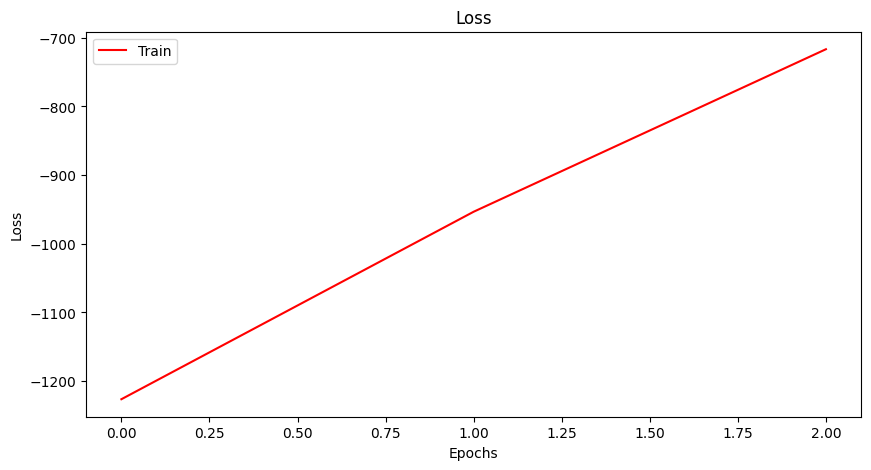

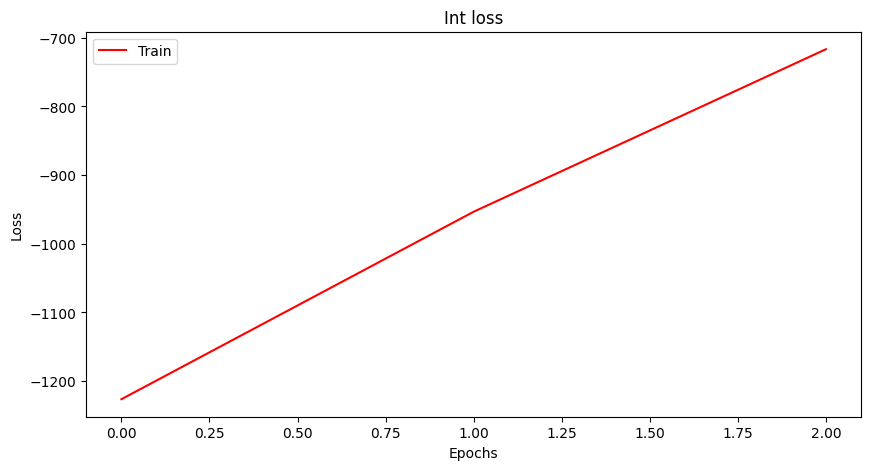

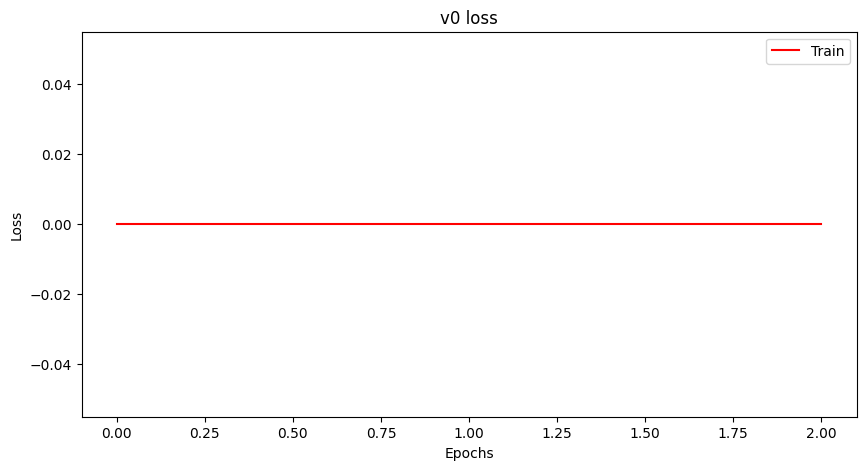

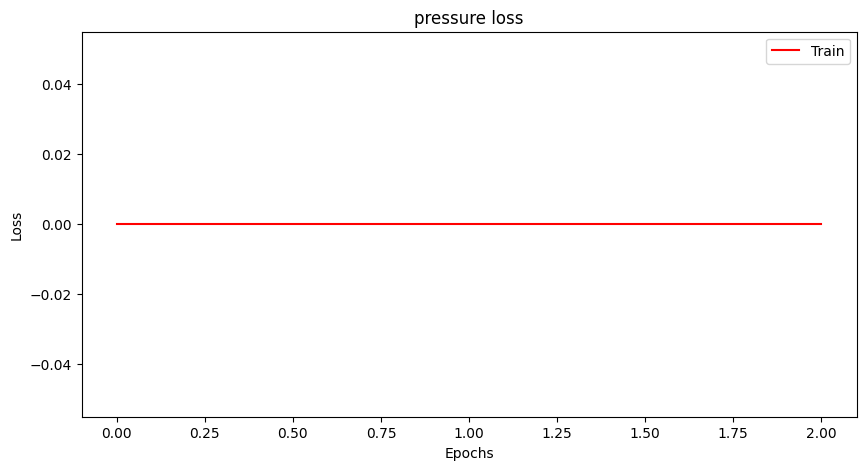

In [174]:
plot_train_history(best_run['history'])

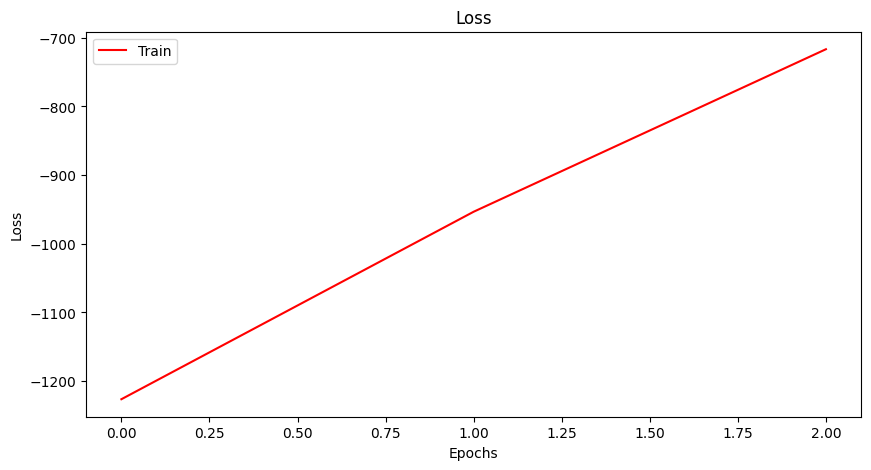

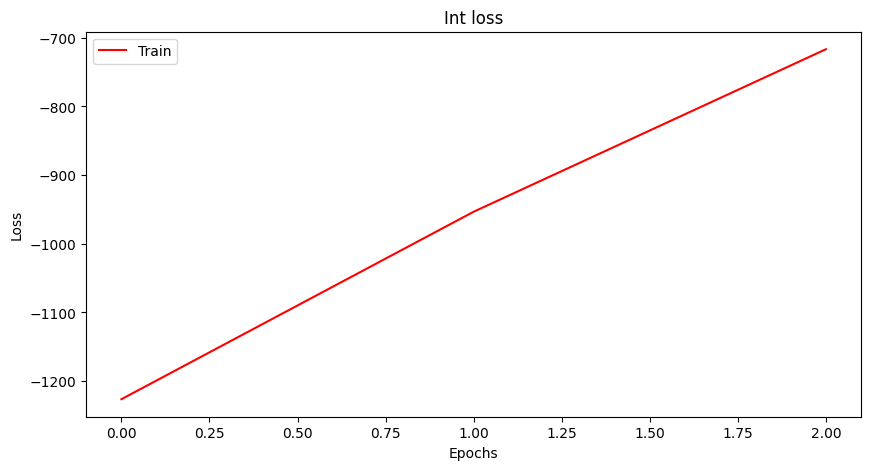

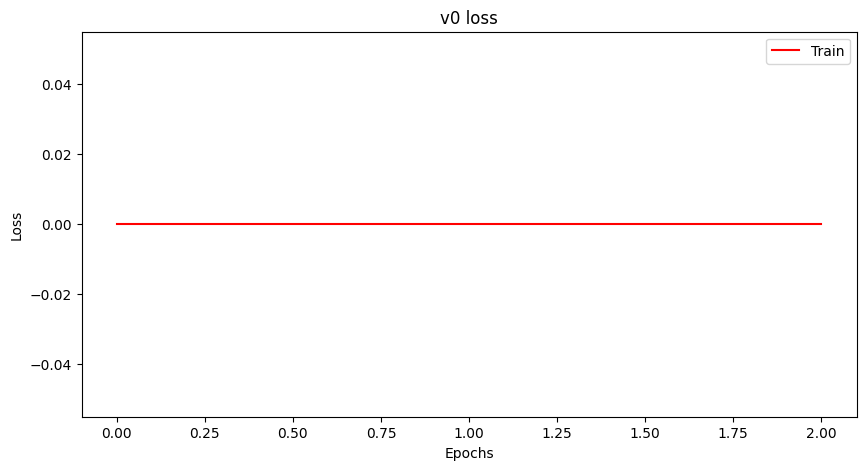

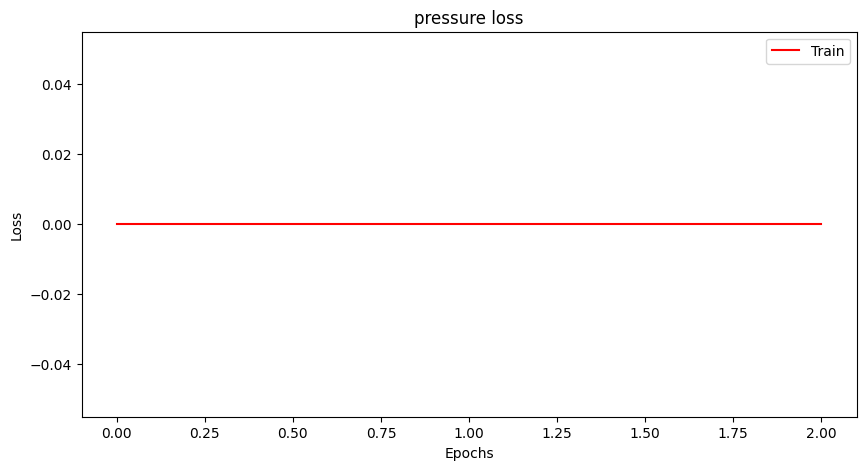

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Tanh()
    (16): Linear(in_features=20, out_features=20, bias=True)
    (17): Tanh()
    (18): Linear(in_features=20, out_features=20, bias=True)
    (19): Tanh()
    (20): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [175]:
# Run if interrupt training

plot_train_history(callbacks[0].history)

model.load_state_dict(torch.load(model_path))
torch.save(model.state_dict(), f'{WORK_DIR}/models/{MODEL_NAME}_best.pth')
model.to(DEVICE)

## Calculate loss

In [176]:
vip, x = model_forward(model)
p, v1, v2, v3, v_abs, loss = inference(vip, x)

print(f'absolute velocity: {v_abs.min()} < abs(V) < {v_abs.max()},')
print(f'mean velocity: {v_abs.mean()},')
print(f'internal power: Int = {loss},')

Eta^2 max: tensor(39530.7227, grad_fn=<MaxBackward1>)
Vgradp min: tensor(-53256520., grad_fn=<MinBackward1>)
absolute velocity: 0.0 < abs(V) < 10.550658226013184,
mean velocity: 1.2911858558654785,
internal power: Int = -1226.2769775390625,


In [177]:
print(p[SIZE // 2,0,:])
print(v3[:,0,SIZE // 2])
print('v3 along x3 =',v3[SIZE // 2, 0, :])
print('v1 along x1 = ',v1[:,0,SIZE // 2])

tensor([100020.0000,  20393.5352,  19527.1328,  18667.0859,  17816.3477,
         16977.9102,  16154.7627,  15349.8691,  14566.1709,  13806.5420,
         13073.8262,  12370.6357,  11699.5918,  11063.0322,  10463.1348,
        100000.0000], grad_fn=<SliceBackward0>)
tensor([ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,   0.0000,
        -10.1235, -10.2130,   0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
         -0.0000,  -0.0000], grad_fn=<SelectBackward0>)
v3 along x3 = tensor([-10.5507, -10.5507, -10.5507, -10.5506, -10.4880, -10.4229, -10.3553,
        -10.2853, -10.2130, -10.1382, -10.0612,  -9.9818,  -9.9001, -10.5507,
        -10.5507, -10.5507], grad_fn=<SliceBackward0>)
v1 along x1 =  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward0>)


In [178]:
print(v1[:,0,:])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

In [179]:
print(v3[:,0,:])

tensor([[ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000],
        [ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000],
        [ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000],
        [ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000],
        [ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000],
        [ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  

In [180]:
print(p[:,0,:])

tensor([[ 25128.2148,  24206.0449,  23263.4355,  22303.2324,  21328.6152,
          20343.1504,  19350.6328,  18355.1699,  17361.0430,  16372.6611,
          15394.4893,  14430.9971,  13486.5859,  12565.5400,  11671.9385,
          10809.6357],
        [ 24684.1328,  23763.4707,  22824.6660,  21870.6016,  20904.5059,
          19929.9238,  18950.7070,  17970.8848,  16994.6836,  16026.4512,
          15070.5928,  14131.4736,  13213.3965,  12320.4922,  11456.7793,
          10625.9346],
        [ 24225.0527,  23307.2383,  22373.7676,  21427.5957,  20471.9902,
          19510.4648,  18546.8379,  17585.0859,  16629.3652,  15683.9365,
          14753.0537,  13840.9844,  12951.8789,  12089.7295,  11258.3965,
          10461.3672],
        [ 23752.4238,  22838.8184,  21912.3027,  20975.8613,  20032.7363,
          19086.4590,  18140.7598,  17199.5508,  16266.8438,  15346.7959,
          14443.5195,  13561.0879,  12703.4902,  11874.5508,  11077.8623,
          10316.8301],
        [ 23268.0156

In [181]:
# Divergence
dv1dx1, dv2dx2, dv3dx3, divV = divVel(v1,v2,v3,DX1N,DX2N,DX3N,L[0],L[1],L[2])

In [182]:
DX2N,DX3N,L[0],L[1],L[2]

(tensor(0.0667), tensor(0.0667), 0.4, 1, 0.4)

In [183]:
divv31, divv33 = num_diff2D(v3[:,0,:],DX1N,DX3N)
v3[SIZE // 2, 0, :], divv31[SIZE // 2, :],divv33[SIZE // 2, :]

(tensor([-10.5507, -10.5507, -10.5507, -10.5506, -10.4880, -10.4229, -10.3553,
         -10.2853, -10.2130, -10.1382, -10.0612,  -9.9818,  -9.9001, -10.5507,
         -10.5507, -10.5507], grad_fn=<SliceBackward0>),
 tensor([79.1299, 79.1299, 79.1299, 78.6332, 78.1239, 77.5978, 77.0558, 76.4984,
         75.9263, 75.3402, 74.7404, 74.1273, 73.5010, 79.1299, 79.1299, 79.1299],
        grad_fn=<SliceBackward0>),
 tensor([ 0.0000e+00,  0.0000e+00,  4.0054e-04,  4.7000e-01,  9.5797e-01,
          9.9514e-01,  1.0317e+00,  1.0676e+00,  1.1031e+00,  1.1382e+00,
          1.1732e+00,  1.2082e+00, -4.2663e+00, -4.8791e+00,  0.0000e+00,
          7.1526e-06], grad_fn=<SliceBackward0>))

In [184]:
v1.max(),v2.max(),v3.max()

(tensor(0., grad_fn=<MaxBackward1>),
 tensor(0.),
 tensor(-0., grad_fn=<MaxBackward1>))

In [185]:
print('divV = ', divV[:,0,:])
print(dv1dx1[:,0,:].min(), dv2dx2[:,0,:].min(), dv3dx3[:,0,:].min(), divV[:,0,:].min())
print(dv1dx1[:,0,:].max(), dv2dx2[:,0,:].max(), dv3dx3[:,0,:].max(), divV[:,0,:].max())

divV =  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.

In [186]:
#@title


## Visualization

Pressure Visualization


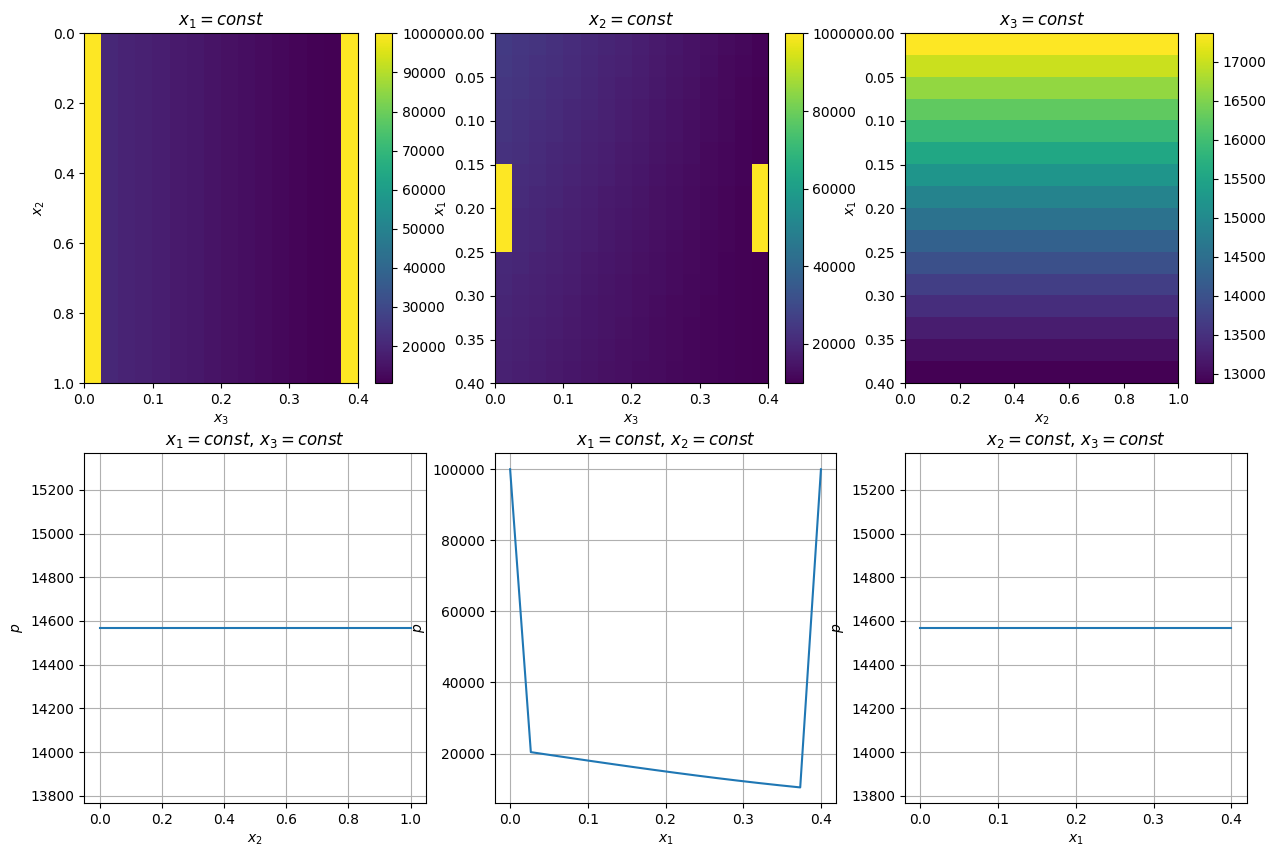


Velocity distribution visualization without flow domain mask (first line) and with mask (second line)


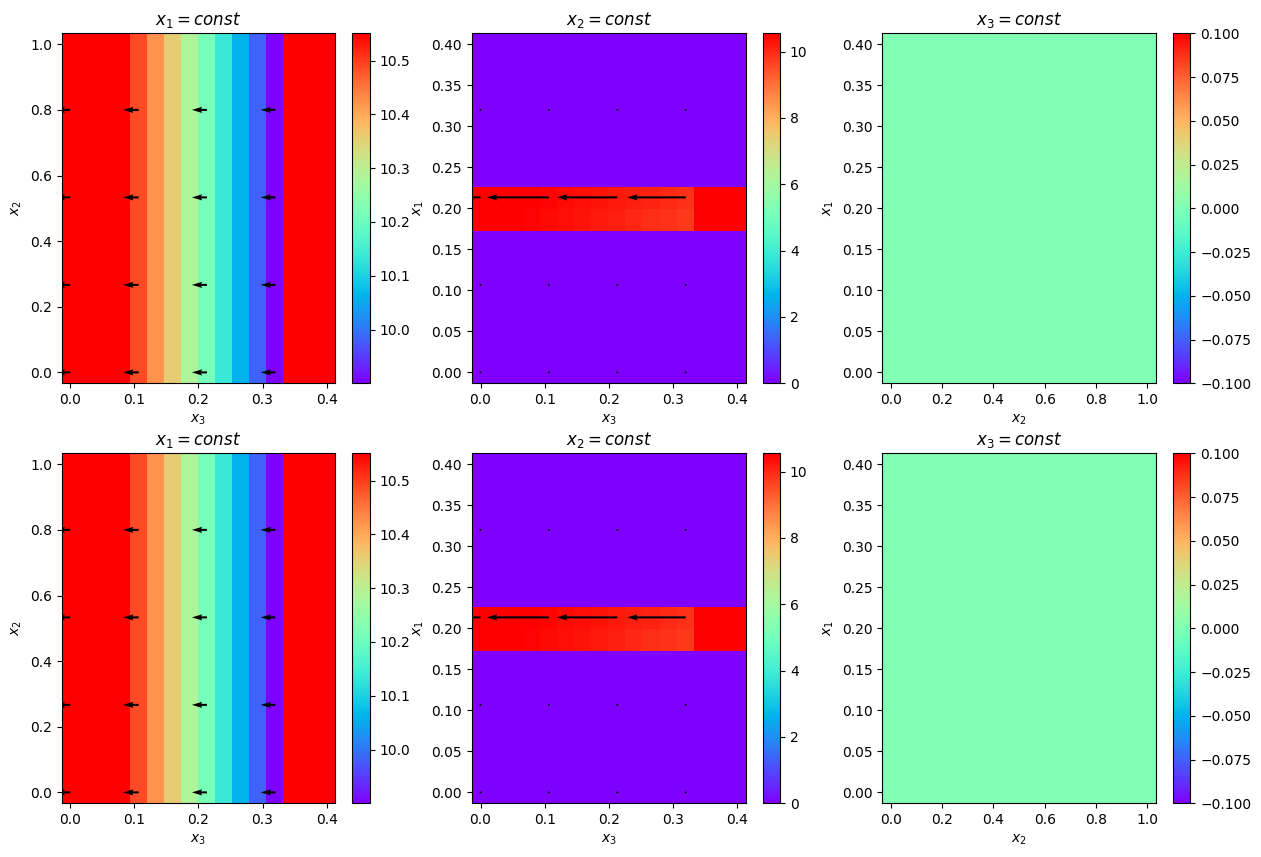

0.0 < v_1 < 0.0,
0.0 < v_2 < 0.0,
-10.550658226013184 < v_3 < -0.0,
Q1- = 0.0, Q1+ = 0.0 - solution
Q2- = 0.0, Q2+ = 0.0 - solution
Q3- = -0.5627018809318542, Q3+ = -0.5627018809318542 - solution
v_abs[0,0,0] = 0.0, v_abs[0,0,-1] = 0.0, v_abs[0,-1,0] = 0.0, v_abs[0,-1,-1] = 0.0, v_abs[-1,0,0] = 0.0, v_abs[-1,0,-1] = 0.0, v_abs[-1,-1,0] = 0.0, v_abs[-1,-1,-1] = 0.0,



In [187]:
flowVisualization(p.detach().cpu(),
                  v1.detach().cpu(), v2.detach().cpu(), v3.detach().cpu(), v_abs.detach().cpu(), step=4, use_mask=False)

$V$ contours and slices

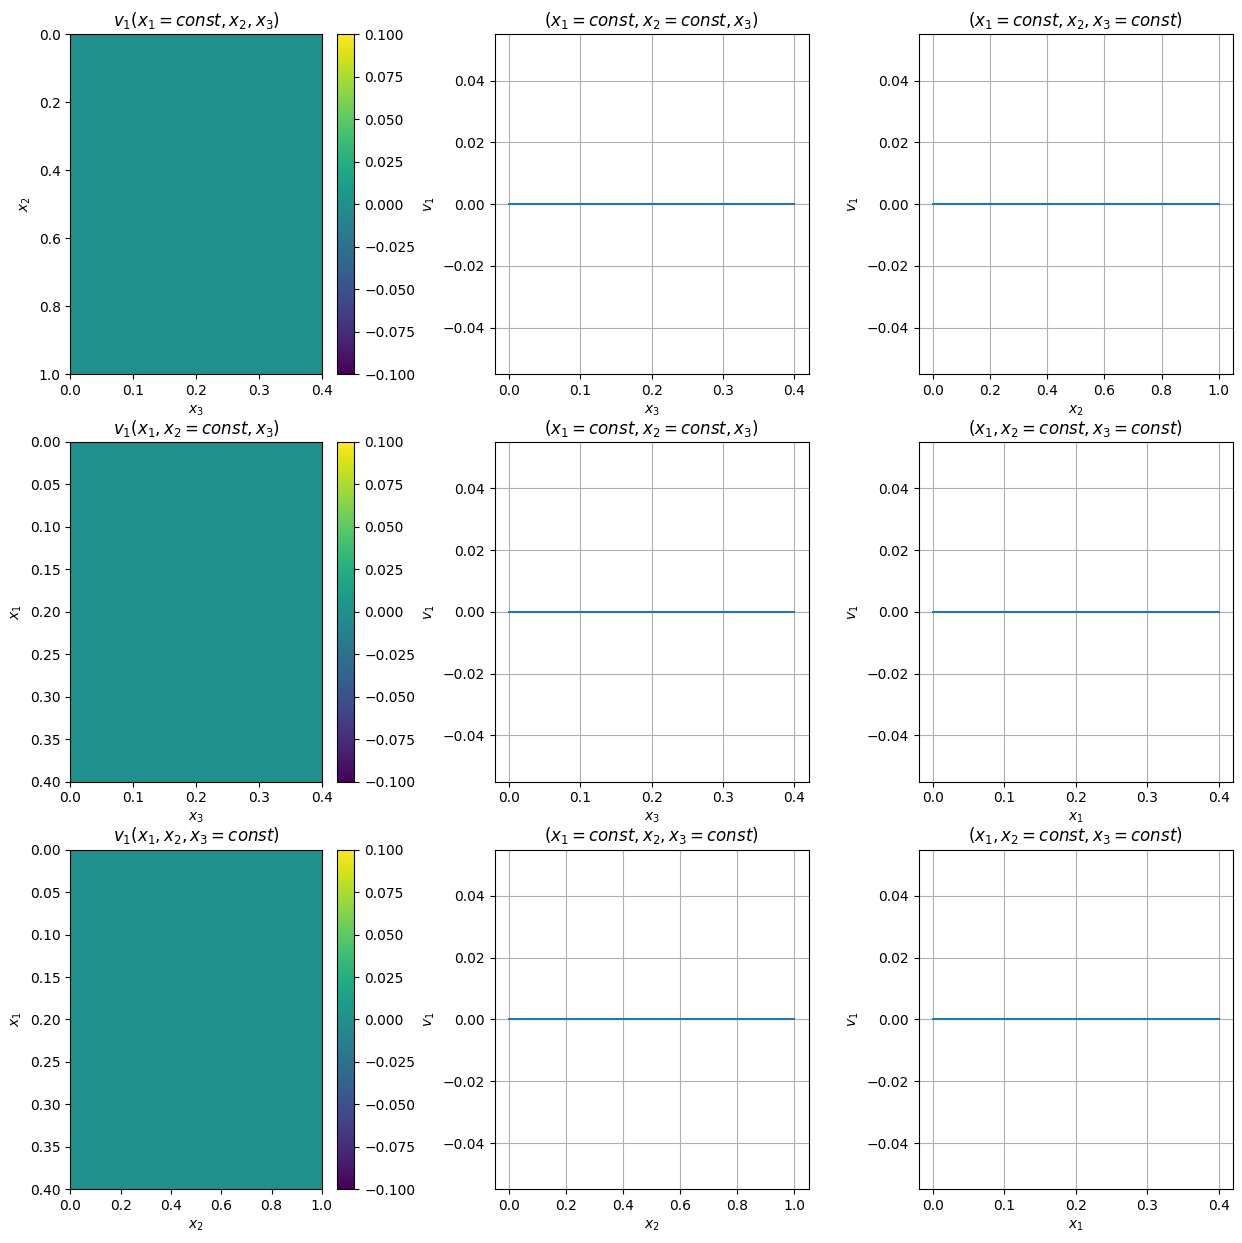

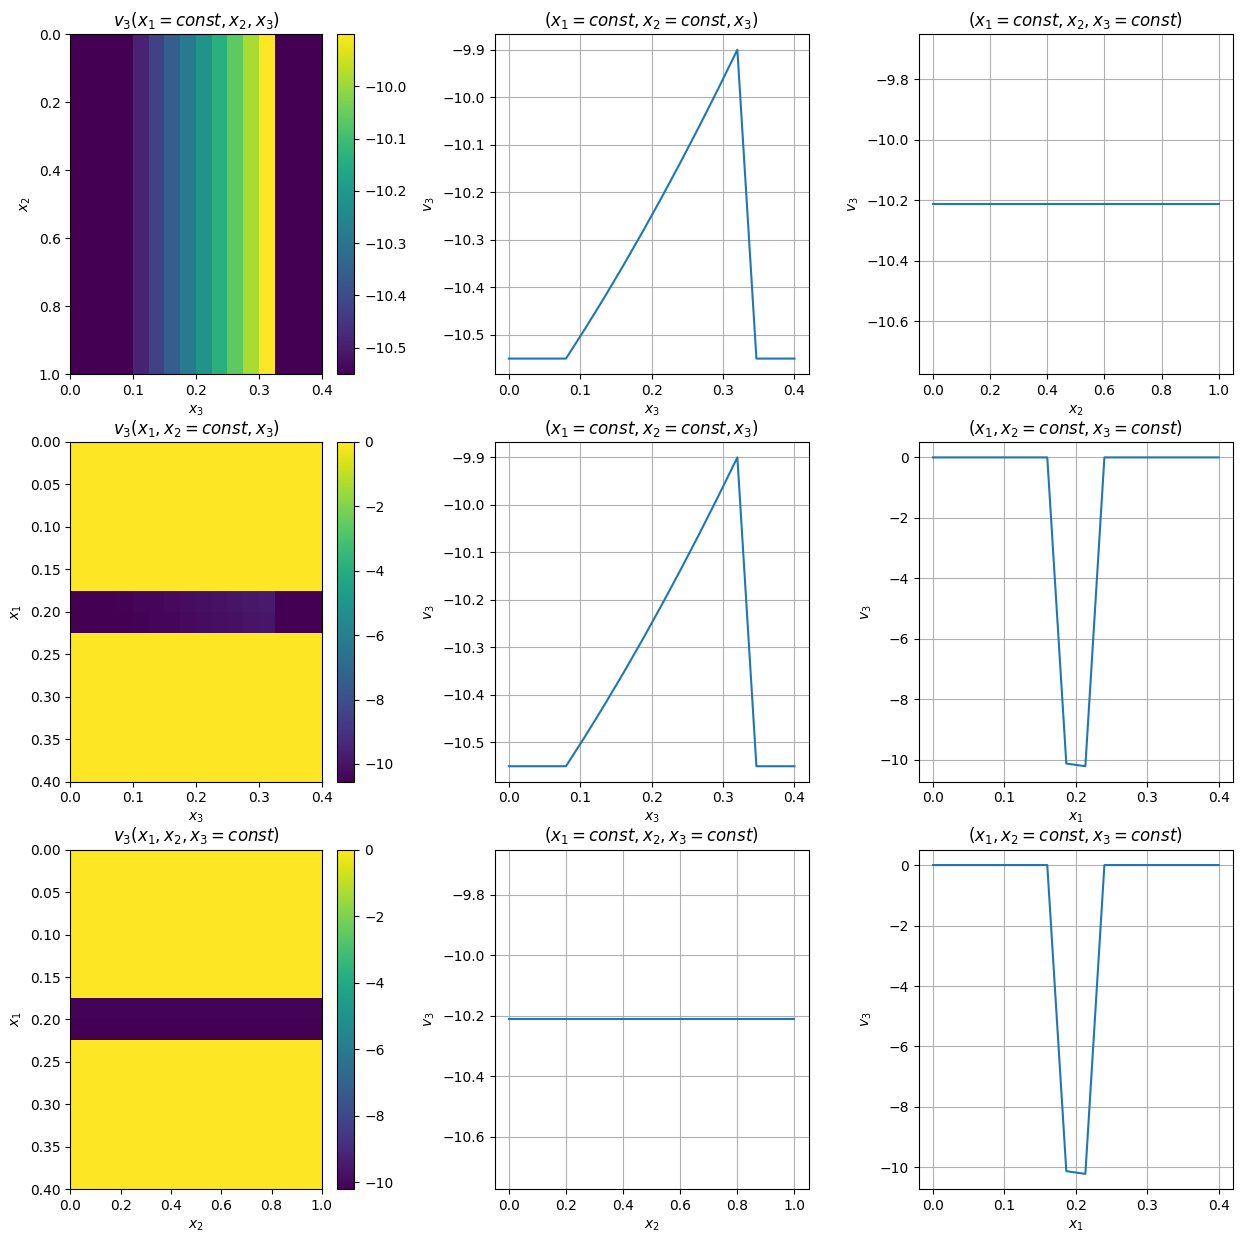

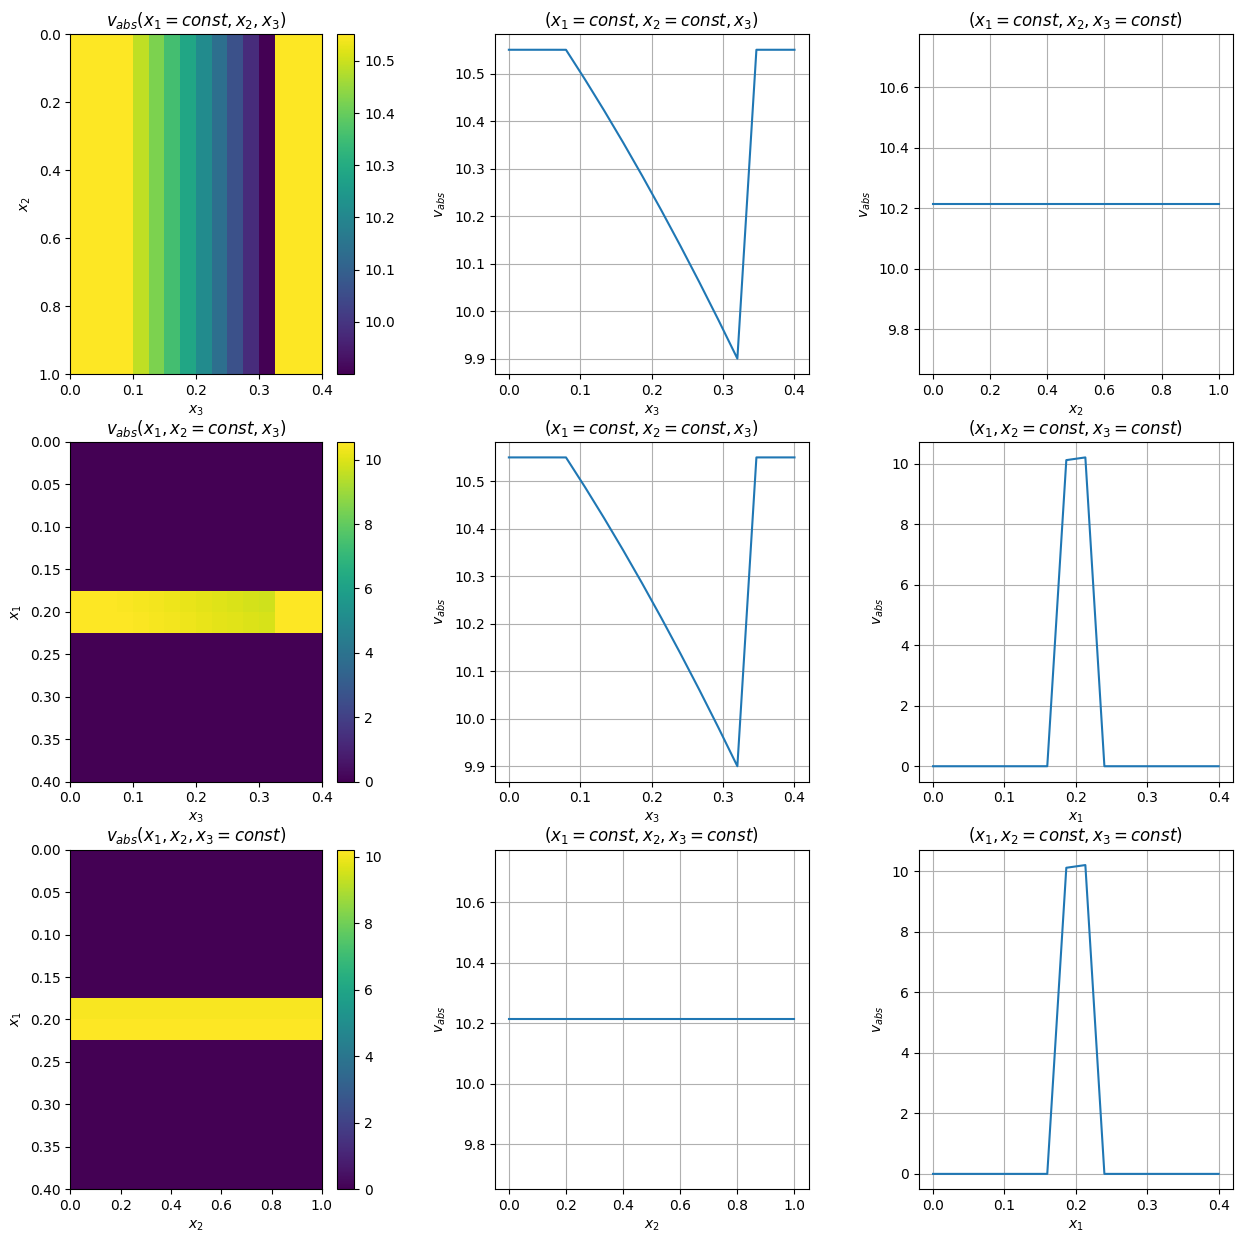

In [188]:
v_contours_and_slices(v1.detach().cpu() * MASK.cpu()[0], 1)
if USE_3D:
    v_contours_and_slices(v2.detach().cpu() * MASK.cpu()[0], 2)
v_contours_and_slices(v3.detach().cpu() * MASK.cpu()[0], 3)
v_contours_and_slices(v_abs.detach().cpu() * MASK.cpu()[0], 'abs')

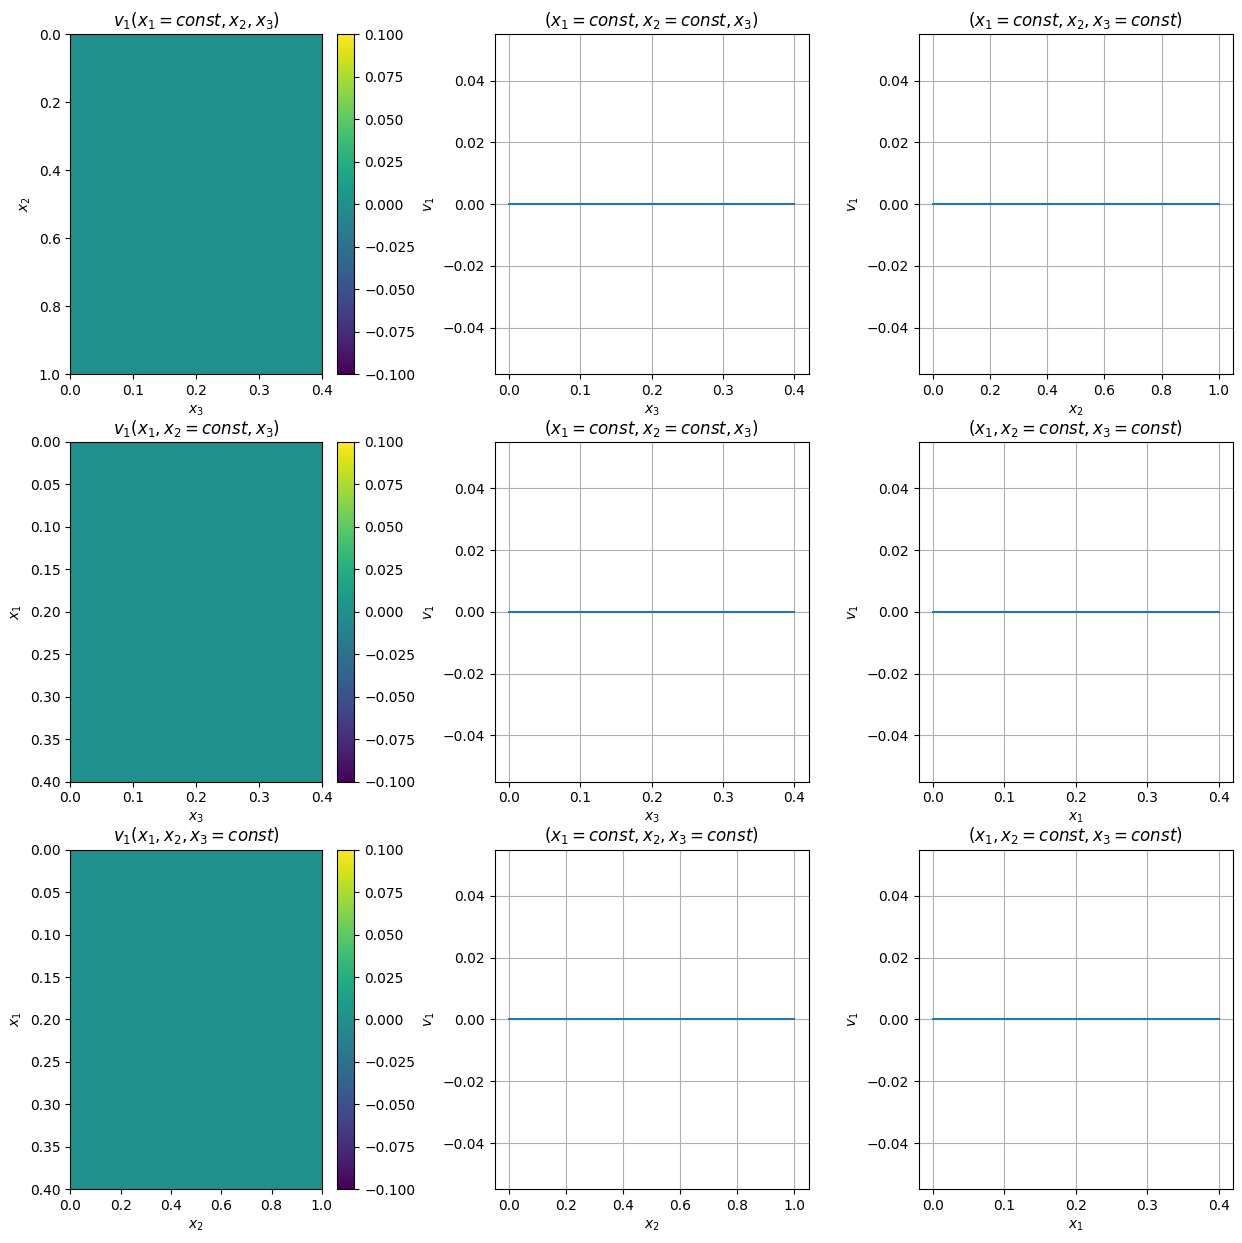

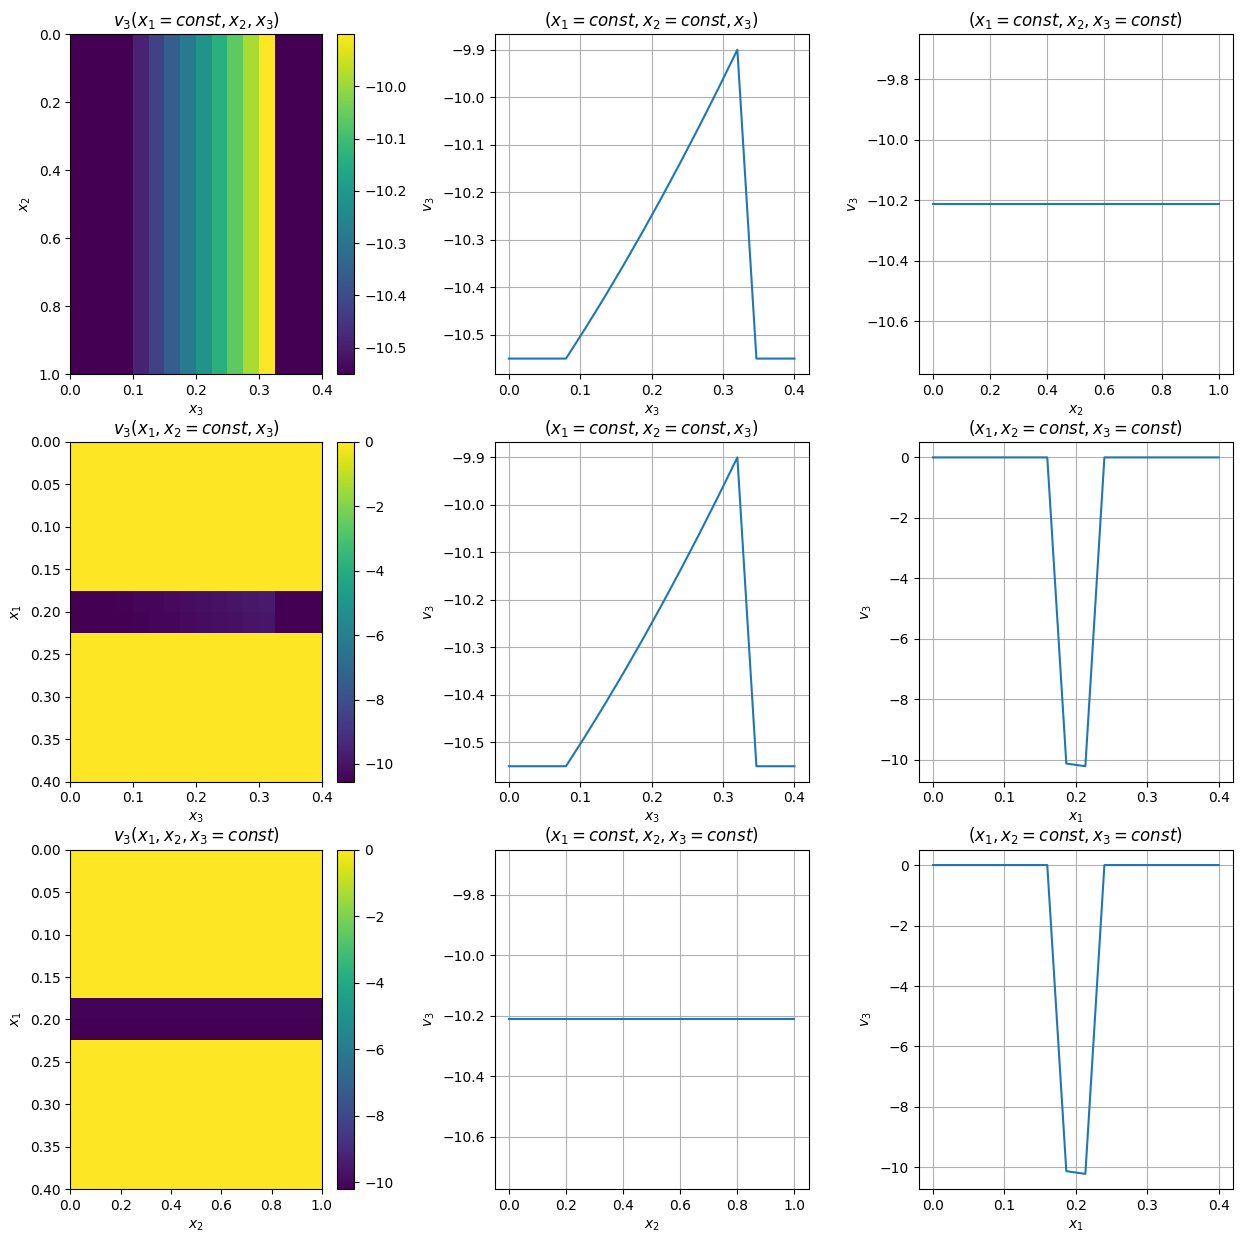

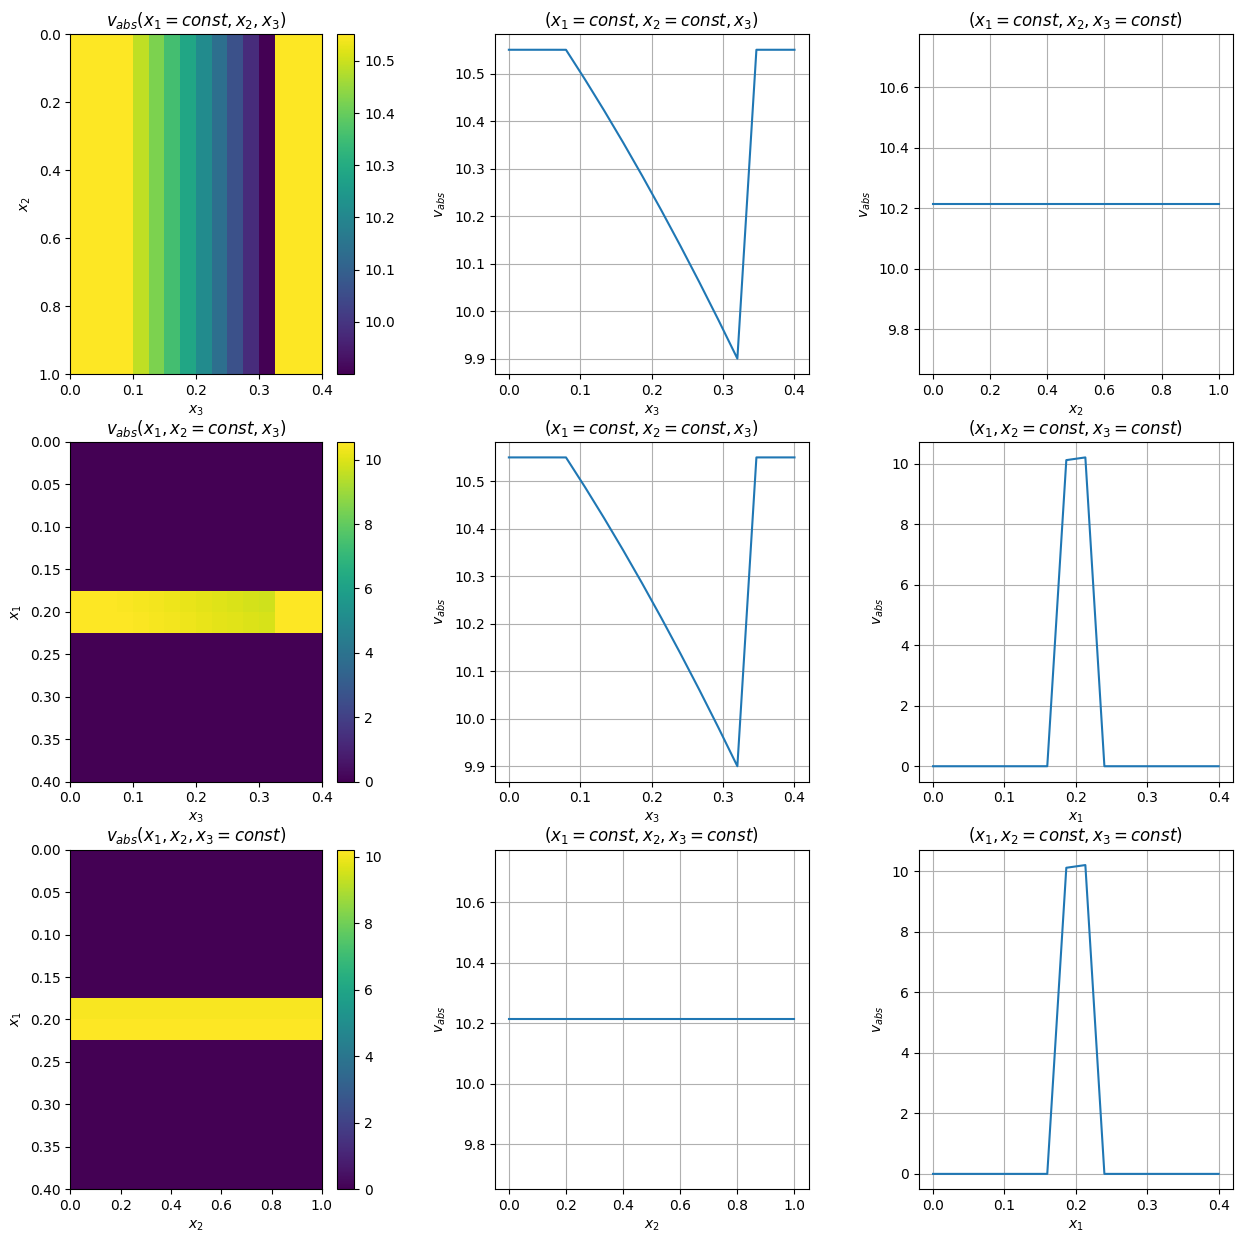

In [189]:
v_contours_and_slices(v1.detach().cpu(), 1)
if USE_3D:
    v_contours_and_slices(v2.detach().cpu(), 2)
v_contours_and_slices(v3.detach().cpu(), 3)
v_contours_and_slices(v_abs.detach().cpu(), 'abs')

$V$ surface

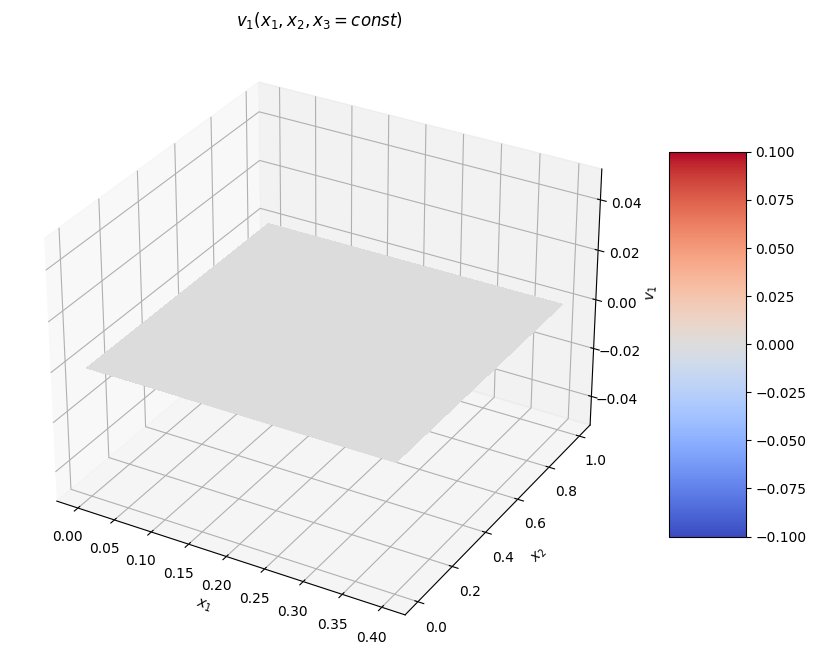

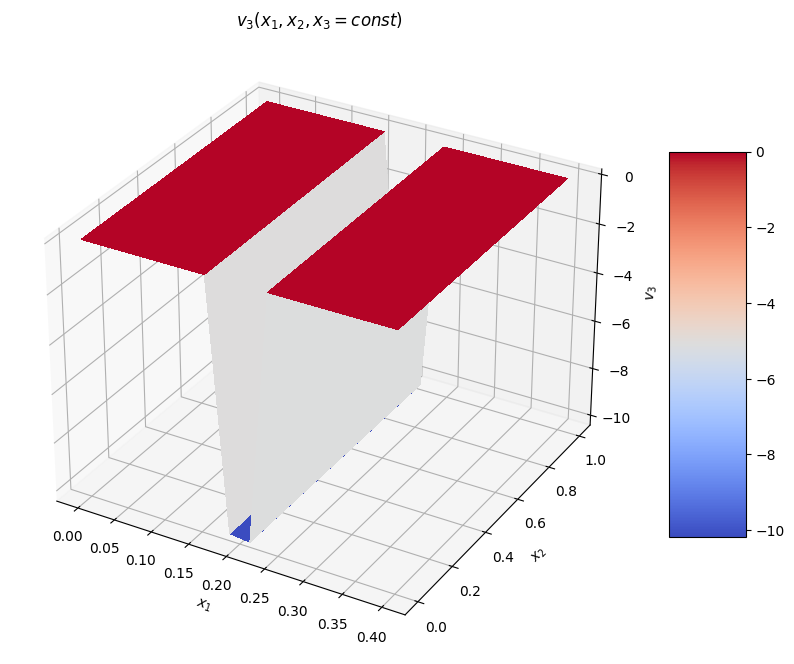

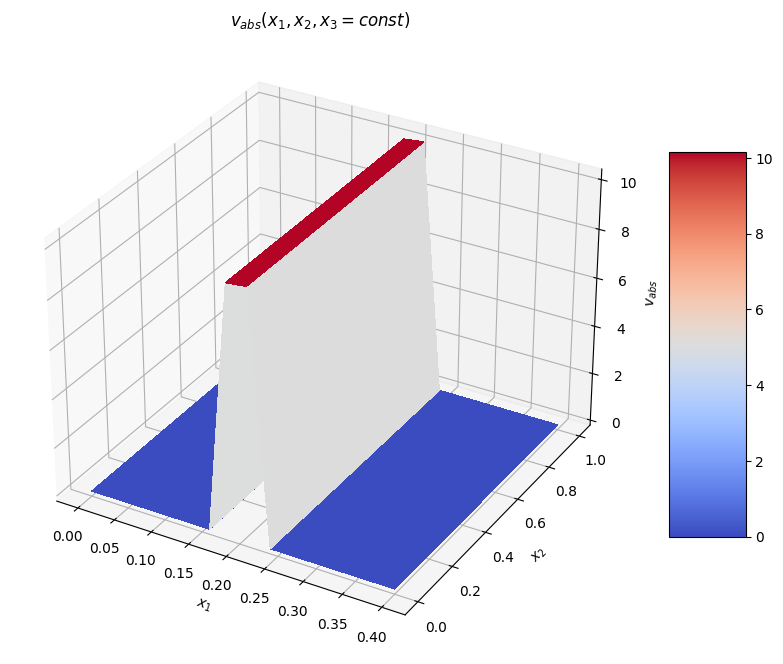

In [190]:
v_surf(v1.detach().cpu() * MASK.cpu()[0], X3_1 * L[0], X3_2 * L[1], 1)
if USE_3D:
    v_surf(v2.detach().cpu() * MASK.cpu()[0], X3_1 * L[0], X3_2 * L[1], 2)
v_surf(v3.detach().cpu() * MASK.cpu()[0], X3_1 * L[0], X3_2 * L[1], 3)
v_surf(v_abs.detach().cpu() * MASK.cpu()[0], X3_1 * L[0], X3_2 * L[1], 'abs')

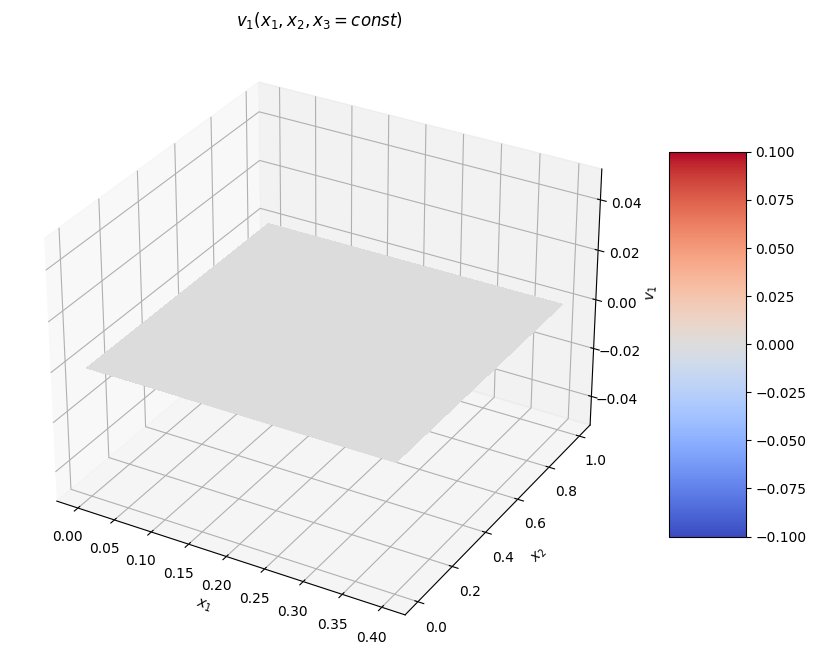

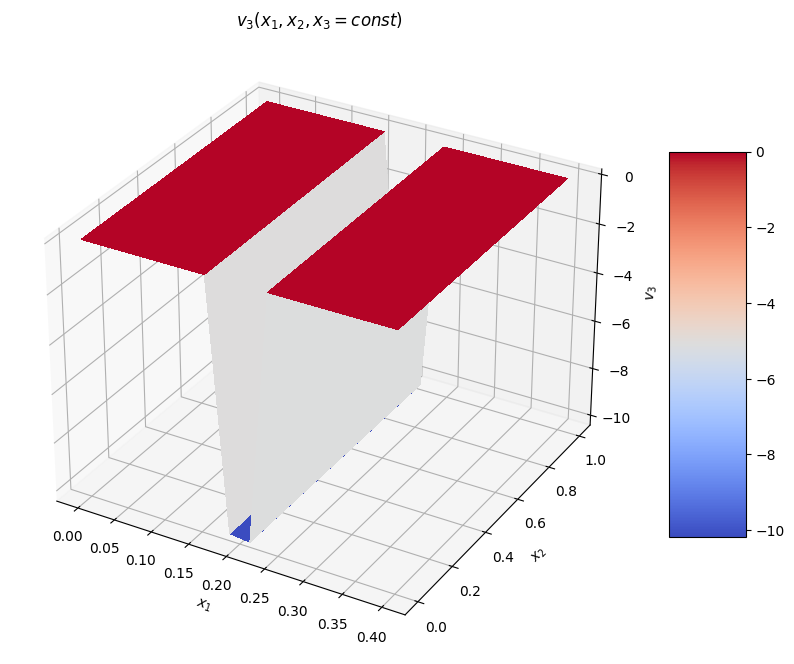

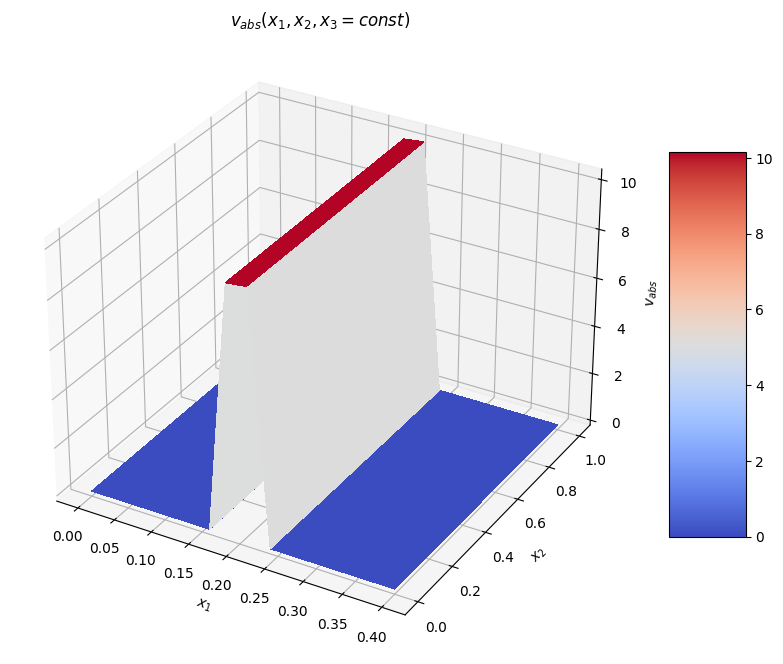

In [191]:
v_surf(v1.detach().cpu(), X3_1 * L[0], X3_2 * L[1], 1)
if USE_3D:
    v_surf(v2.detach().cpu(), X3_1 * L[0], X3_2 * L[1], 2)
v_surf(v3.detach().cpu(), X3_1 * L[0], X3_2 * L[1], 3)
v_surf(v_abs.detach().cpu(), X3_1 * L[0], X3_2 * L[1], 'abs')

$V$ 3D

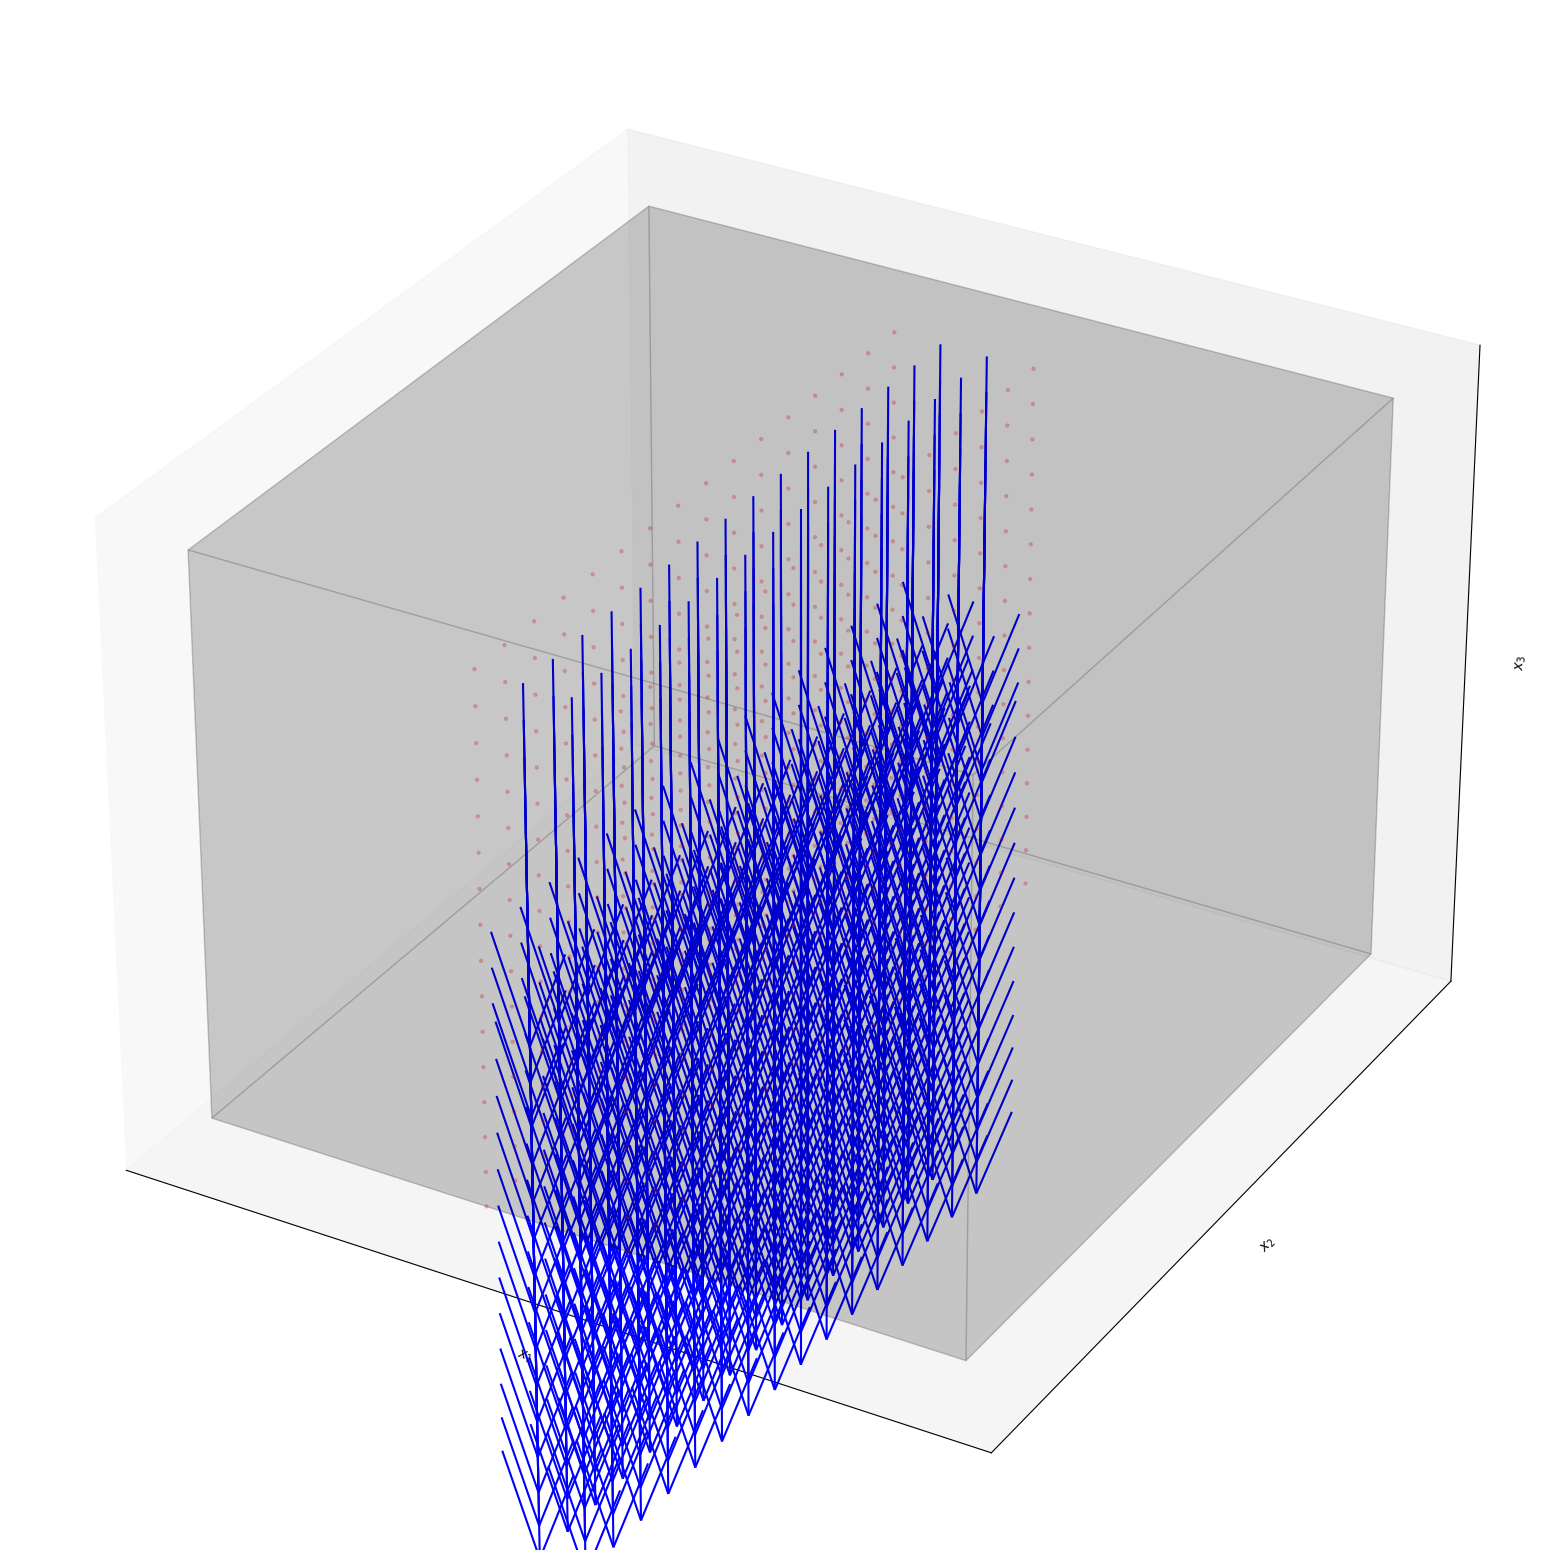

In [192]:
x = np.meshgrid(np.arange(0, SIZE, STEP3D),
                np.arange(0, SIZE, STEP3D),
                np.arange(0, SIZE, STEP3D), indexing='ij')

v_all = torch.stack((v1.cpu() * MASK[0].cpu() / L[0], v2.cpu() * MASK[0].cpu() / L[1], v3.cpu() * MASK[0].cpu() / L[2]), 3).detach()
v_abs = torch.sqrt(v_all[:, :, :, 0] ** 2 + v_all[:, :, :, 1] ** 2 + v_all[:, :, :, 2] ** 2)

vector_plot_3d(x, v_all / v_abs.max(), v_abs, figSize=FIGSIZE*4, step=STEP3D)

 # Links

[1]. https://github.com/Mechanics-Mechatronics-and-Robotics/Mathematical_modelling/blob/main/Practice_1_by_IStebakov.ipynb

[2]. https://github.com/mateuszbuda/brain-segmentation-pytorch